In [ ]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

import seaborn as sns
import cebra
from cebra import CEBRA
import pickle

from data_utils import (
    load_data_from_dir,
)
from labels import get_behavioral_labels
from plotting import subplot_confusion_matrix
from constants import AUDIO_BLOCKS
from features.constants import Feature, MARKER_TO_FEATURE

data_dir = "../CleandDataV2/"
random.seed(33)

## Helper functions

In [ ]:
from feature_extraction import EEG_BANDS

def get_categorical_labels(blocks, subject_data):
    behavioral_labels = []

    for b in blocks:
        block_data = subject_data[b]
        v_label = block_data.get_labels()
        a_label = block_data.get_labels("arousal")

        labels = [
            get_behavioral_labels(v_label[i], a_label[i]) for i in range(len(v_label))
        ]
        behavioral_labels.extend(labels)

    return behavioral_labels


def get_label_category(labels, label_type, v_thred, a_thred):
    threshold = a_thred if label_type == "arousal" else v_thred
    return [0 if p < threshold else 1 for p in labels]

## Load data and process features

In [ ]:
import os

# Read labels pkl file
with open("./data/behavioral_labels.pkl", "rb") as fp:
    behavioral_labels = pickle.load(fp)

valence_labels, arousal_labels, attention_labels = (
    behavioral_labels["valence_labels"],
    behavioral_labels["arousal_labels"],
    behavioral_labels["attention_labels"],
)
print(len(valence_labels), len(valence_labels[0]))

marker = "EEG"
num_slice_per_trial = 5

subject_list = []
label_thresholds = []
idx = 0
for d in os.listdir(data_dir):
    dir_name = data_dir + d
    if not os.path.isdir(dir_name):
        continue

    vl, arl = valence_labels[idx], arousal_labels[idx]
    subject_list.append(d)
    label_thresholds.append((np.mean(vl), np.mean(arl)))
    idx += 1

In [ ]:
# Read dictionary pkl file
with open('./eeg_features2/all_features.pkl', 'rb') as fp:
    marker_features = pickle.load(fp)
len(marker_features)

In [ ]:
IDX_MAP = {
    "hvha": 0,
    "hvla": 1,
    "nvha": 2,
    "nvla": 3,
}
target_names = list(IDX_MAP.keys())

cat_labels = []
for idx, (v_thred, a_thred) in enumerate(label_thresholds):
    vc = [ 'hv' if l > v_thred else 'nv' for l in valence_labels[idx]]
    ac = [ 'ha' if l > a_thred else 'la' for l in arousal_labels[idx]]
    vac = [ IDX_MAP[vc[i]+ac[i]] for i in range(len(vc))]
    cat_labels.append(vac)
len(cat_labels)

### Data inspection

In [ ]:
target_subject = '2041'
for i in range(len(subject_list)):
    if subject_list[i] == target_subject:
        g = sns.histplot(data=[target_names[a]for a in cat_labels[i]], stat='percent') #, color='#fffea3'
        g.set_title(target_subject)
        

In [ ]:
nrows = 5
ncol = 8
fig, axes = plt.subplots(
    nrows=nrows,
    sharey=True,
    ncols=ncol,
    figsize=(ncol * 3, nrows * 4),
)

for i in range(len(axes.flat)):
    g = sns.histplot(
        data=[target_names[a] for a in cat_labels[i]], #['ha' if 'ha' in target_names[a] else 'la' for a in cat_labels[i]]
        stat="percent",
        ax=axes.flat[i],
        #color="#fffea3",
    )
    g.set_title(subject_list[i])

## Model Training

### Training utils

In [ ]:
# @title One Over Rest distribution and ROC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

# Plots the Probability Distributions and the ROC Curves One vs Rest
bins = [i/20 for i in range(20)] + [1]

def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

def _plot_one_over_rest_roc(y_true, y_pred, method, label_type):
  from sklearn.metrics import ConfusionMatrixDisplay
  title = f'{method}:{label_type}'
  # Compuate the confusion matrix
  disp = ConfusionMatrixDisplay.from_predictions(
      y_true,
      np.argmax(y_pred, axis=1),
      display_labels=target_names,
      cmap=plt.cm.Blues,
      normalize='true')
  # Set the fixed color bar range
  disp.im_.set_clim(0, 1)
  disp.ax_.set_title(title)
  
  y_true_one_hot = one_hot(y_true, len(target_names))

  plt.figure(figsize = (12, 8))
  roc_auc_ovr = {}
  for i in range(len(target_names)):
      c = target_names[i]
      # Prepares an auxiliar dataframe to help with the plots
      df_aux = {}
      df_aux['class'] = y_true_one_hot[:, i]
      df_aux['prob'] = y_pred[:, i]

      # Plots the probability distribution for the class and the rest
      ax = plt.subplot(2, len(target_names), i+1)
      sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
      ax.set_title(c)
      ax.legend([f"Class: {c}", "Rest"])
      ax.set_xlabel(f"P(x = {c})")

      # Calculates the ROC Coordinates and plots the ROC Curves
      ax_bottom = plt.subplot(2, len(target_names), i+5)
      RocCurveDisplay.from_predictions(
          df_aux['class'],
          df_aux['prob'],
          name=c,
          #color=color,
          ax=ax_bottom,
          #plot_chance_level=(class_id == 2),
      )
      #tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
      #plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
      ax_bottom.set_title(f"ROC Curve OvR for {c}")

      # Calculates the ROC AUC OvR
      roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
      
      plt.tight_layout()
  plt.title(title)

In [ ]:
from sklearn.utils import shuffle

class EEGDataset():
    def __init__(self, val_indexes_group: list):
        self.val_indexes_group = val_indexes_group        
        self.shuffled_val_indexes = []
        self.shuffled_train_indexes = []

    def get_shuffled_indexes(self, behavioral_labels, enabled_shuffle: bool=True):
        for val_indexes in self.val_indexes_group:
            train_indexes = list(set(range(len(behavioral_labels))) - set(val_indexes))
            if enabled_shuffle:
                self.shuffled_train_indexes.append(shuffle(train_indexes, random_state=0))
                self.shuffled_val_indexes.append(shuffle(val_indexes, random_state=0))
            else:
                self.shuffled_train_indexes.append(train_indexes)
                self.shuffled_val_indexes.append(val_indexes)                
        
        return self.shuffled_train_indexes, self.shuffled_val_indexes
    
    def train_test_split(self, data, behavioral_labels):
        dataset = []
        for idx, val_indexes in enumerate(self.shuffled_val_indexes):
            train_indexes = self.shuffled_train_indexes[idx]
            train_labels = np.array(behavioral_labels)[train_indexes]
            train_data = data[train_indexes]

            val_data = data[val_indexes]
            val_label = np.array(behavioral_labels)[val_indexes]
            dataset.append((train_data, train_labels, val_data, val_label))
        
        return dataset   

In [25]:
import ipywidgets as widgets
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score
from model.embedding import get_embeddings

# CEBRA AND PCA hyper-parameters
OUTPUT_DIM = 8
MAX_HIDDEN_UNITS = 256

def _train_test_split(data, labels, val_indexes: list = []):
    train_indexes = list(set(range(len(labels))) - set(val_indexes))
    train_labels = np.array(labels)[train_indexes]
    train_data = data[train_indexes]

    val_data = data[val_indexes]
    val_label = np.array(labels)[val_indexes]
    return train_data, train_labels, val_data, val_label

# output_dim, max_hidden_units only needed for CEBRA
def run_knn_decoder(
    dataset,
    method,
    output_dim,
    max_hidden_units,
):
    from sklearn.neighbors import KNeighborsClassifier

    y_pred, all_embeddings = [], []
    for _, (train_data, train_labels, val_data, _) in enumerate(dataset):
        embedding, val_embedding = get_embeddings(
            train_data=train_data,
            val_data=val_data,
            train_labels=train_labels,
            use_pca=(method == "PCA"),
            out_dim=6 if method == "PCA" else output_dim,
            num_hidden_units=max_hidden_units,
            max_iterations=1000,
        )
        all_embeddings.append((embedding, val_embedding))
        # 4. Train the decoder on training embedding and labels
        # train_true_cat = get_label_category(train_labels, label_type)
        decoder = KNeighborsClassifier(n_neighbors=4)
        decoder.fit(embedding, np.array(train_labels))

        # score = decoder.score(val_embedding, np.array(val_labels))
        prediction = decoder.predict_proba(val_embedding)
        y_pred.append(prediction)

    return y_pred, all_embeddings


def get_all_spectral_features(feature_to_data: dict, eeg_dataset, labels):
    all_spetral_psd = [feature_to_data[f.name] for f in EEG_BANDS.keys()]
    all_spetral_psd = np.hstack(all_spetral_psd)
    return eeg_dataset.train_test_split(all_spetral_psd, labels)

def prepare_dataset(
    data,
    eeg_dataset,
    labels,
    all_spectral_only: bool = False,
):
    dataset_dict = {k: {} for k in data.keys()}
    for channel, feature_to_data in data.items():
        dataset_dict[channel][Feature.ALL_SPECTRAL.name] = get_all_spectral_features(
            feature_to_data, eeg_dataset, labels
        )

        if all_spectral_only:
            continue
        for f, neural_data in feature_to_data.items():
            # Prepare the data
            dataset_dict[channel][f] = eeg_dataset.train_test_split(neural_data, labels)


    return dataset_dict


def decode_marker_data(
    dataset_dict,
    method,
    filtered_channel: str = "",
    plot_roc: bool = False,
):
    accuracy = {k: {} for k in dataset_dict.keys()}
    list_embedding_tuple = []
    for channel, feature_to_data in dataset_dict.items():
        if channel != filtered_channel and len(filtered_channel) > 0:
            continue

        for f, dataset in feature_to_data.items():
            val_true_cat = [
                val_labels for _, (_, _, _, val_labels) in enumerate(dataset)
            ]

            val_pred_cat, all_embeddings = run_knn_decoder(
                dataset,
                method,
                OUTPUT_DIM,
                MAX_HIDDEN_UNITS,
            )
            ac_scores = [
                accuracy_score(
                    y_pred=np.argmax(val_pred_cat[i], axis=1), y_true=val_true_cat[i]
                )
                for i in range(len(val_pred_cat))
            ]
            accuracy[channel][f] = np.mean(ac_scores)

            max_score_index = np.array(ac_scores).argmax(axis=0)
            mean_acc = round(np.mean(ac_scores), 2) 
            max_acc = round(ac_scores[max_score_index], 2)
            list_embedding_tuple.append(
                (
                    f"CV Acc Max: {max_acc} Avg:{mean_acc}",
                    max_score_index,
                    all_embeddings[max_score_index],
                    (dataset[max_score_index][1], dataset[max_score_index][3]),
                )
            )

            if plot_roc:
                y_pred, y_true = [], []
                for i in range(len(val_true_cat)):
                    y_true.extend(val_true_cat[i])
                    y_pred.extend(val_pred_cat[i])

                _plot_one_over_rest_roc(
                    np.array(y_true), np.array(y_pred), channel, f,
                )            

    return list_embedding_tuple, accuracy

### Cross Validation

In [ ]:
from resample.resample import get_consecutive_validation_indexes

n_step_trial = 3
val_indexes = [
    get_consecutive_validation_indexes(
        len(valence_labels[0]), len(AUDIO_BLOCKS), num_slice_per_trial, i, n_step_trial
    )
    for i in range(1, 13, n_step_trial)
]
print(len(val_indexes), val_indexes)

### Get subjects summary

decoding subject... 2040
decoding subject... 2013
decoding subject... 2022
decoding subject... 2025
decoding subject... 2046
decoding subject... 2041


/Users/ccnlab/miniconda3/envs/MM/lib/python3.8/site-packages/cebra/integrations/matplotlib.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(figsize=figsize, dpi=dpi)


decoding subject... 2024
decoding subject... 2012
decoding subject... 2037
decoding subject... 2001
decoding subject... 2039
decoding subject... 2006
decoding subject... 2038
decoding subject... 2007
decoding subject... 2000
decoding subject... 2009
decoding subject... 2036
decoding subject... 2031
decoding subject... 2017
decoding subject... 2028
decoding subject... 2010
decoding subject... 2026
decoding subject... 2019
decoding subject... 2021
decoding subject... 2044
decoding subject... 2043
decoding subject... 2020
decoding subject... 2018
decoding subject... 2011
decoding subject... 2016
decoding subject... 2029
decoding subject... 2042
decoding subject... 2045
decoding subject... 2034
decoding subject... 2033
decoding subject... 2005
decoding subject... 2002
decoding subject... 2003
decoding subject... 2004
decoding subject... 2032
decoding subject... 2035


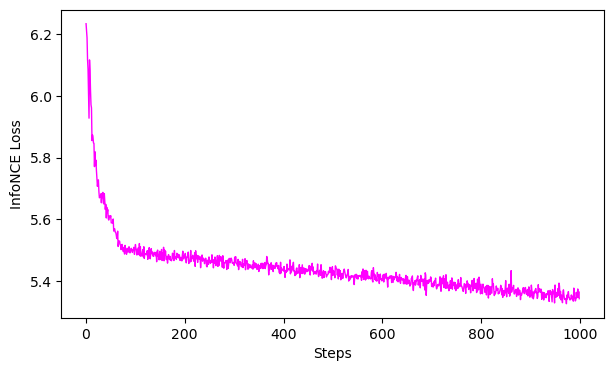

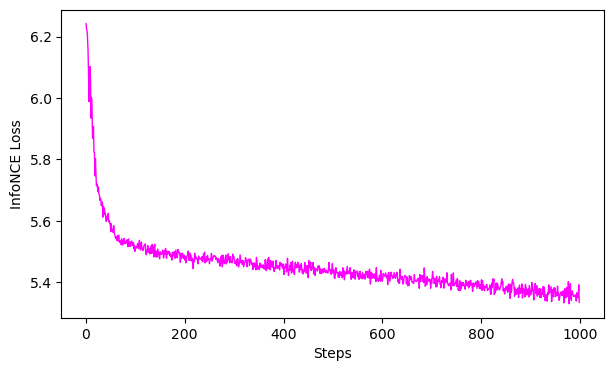

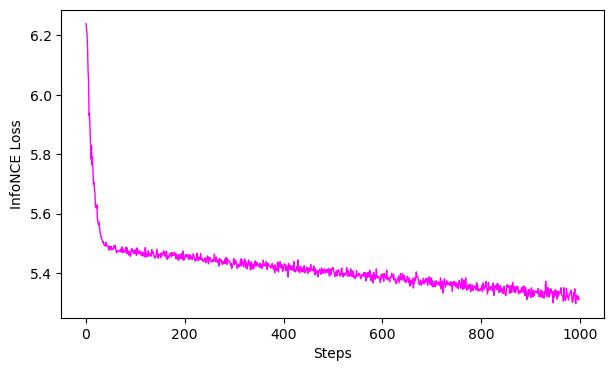

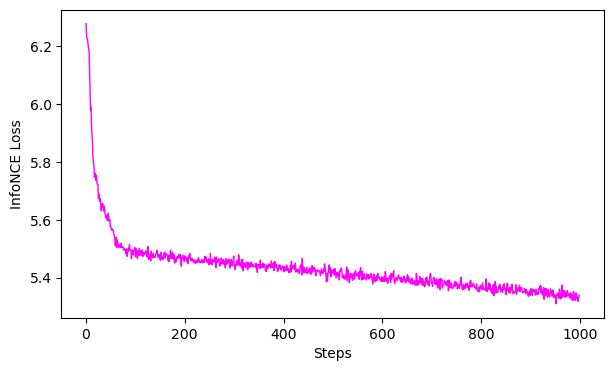

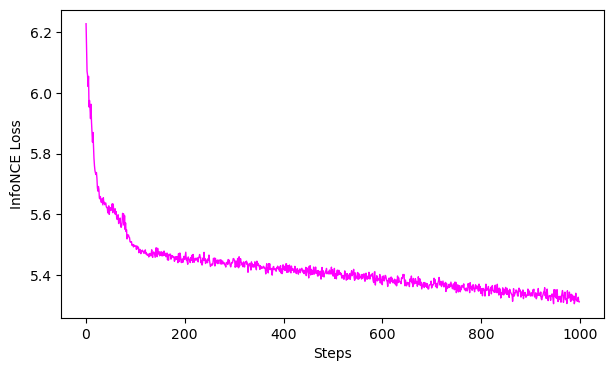

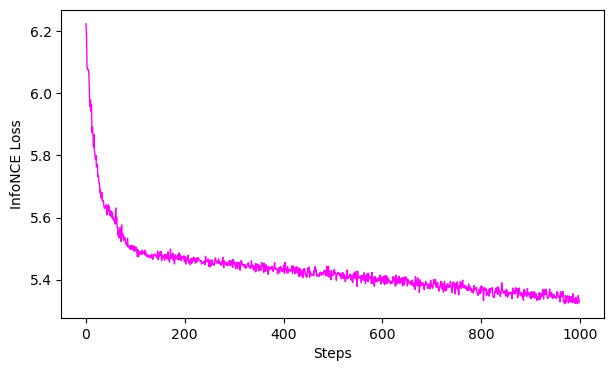

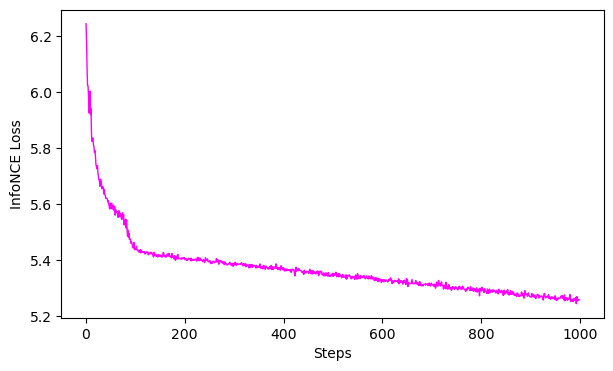

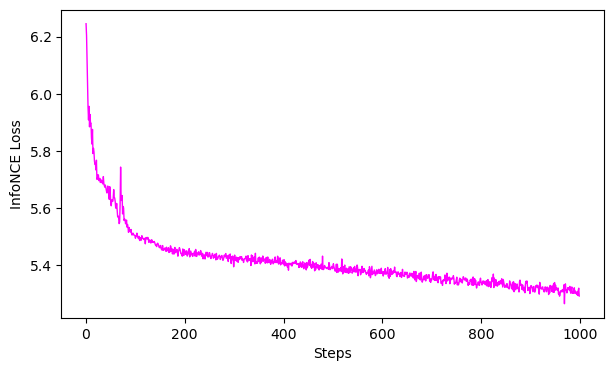

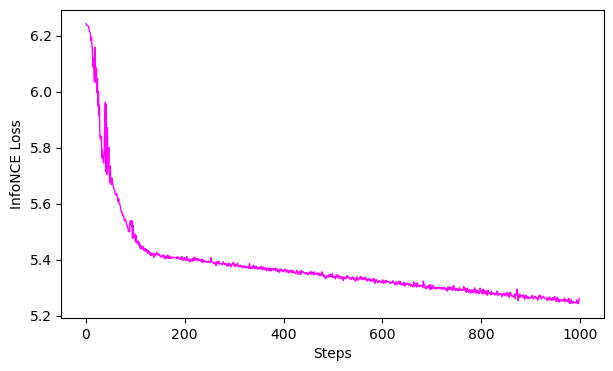

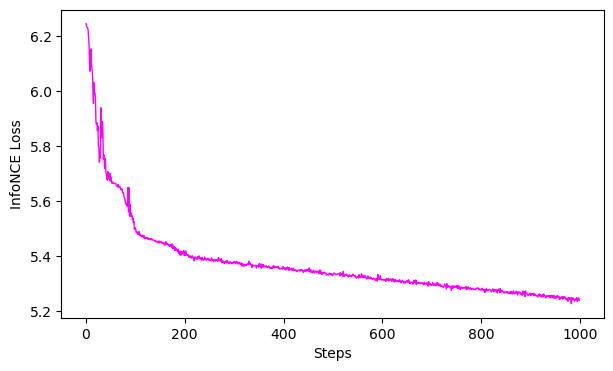

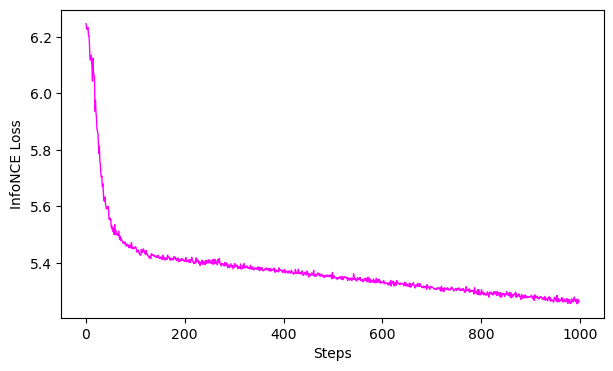

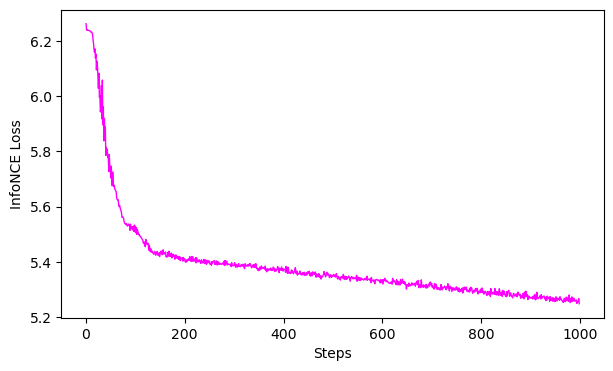

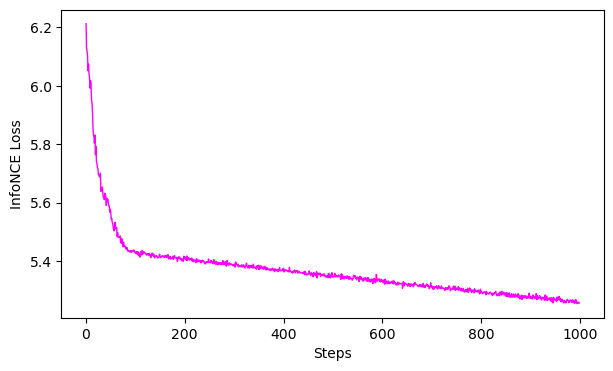

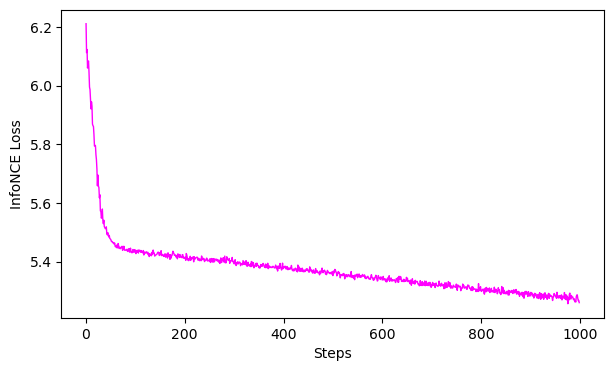

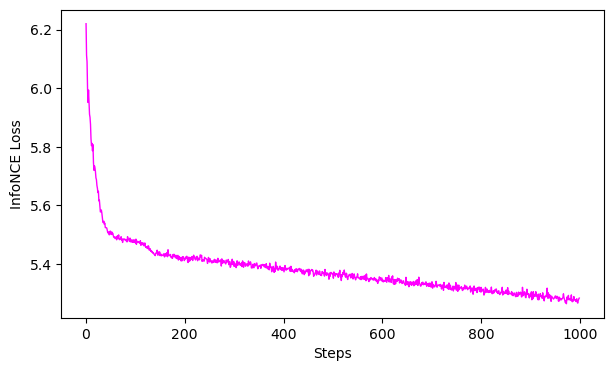

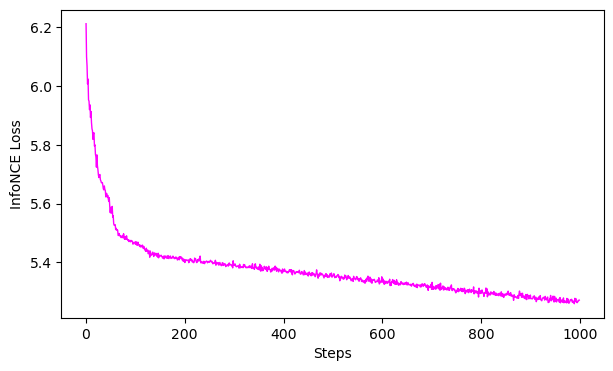

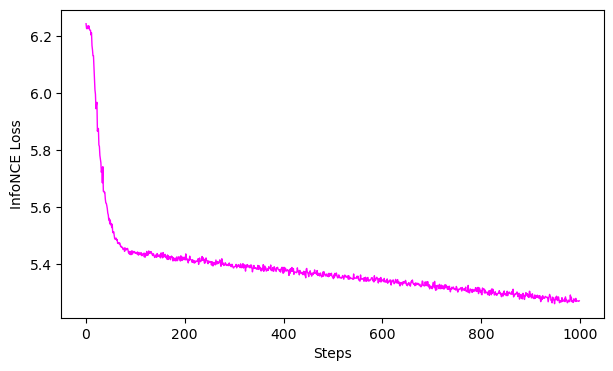

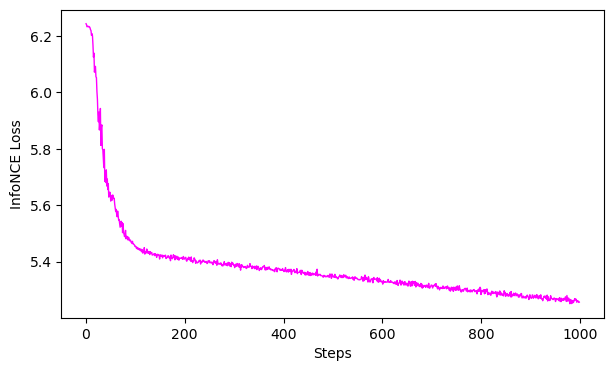

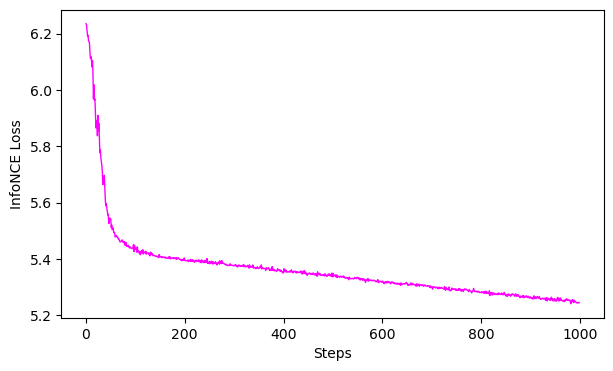

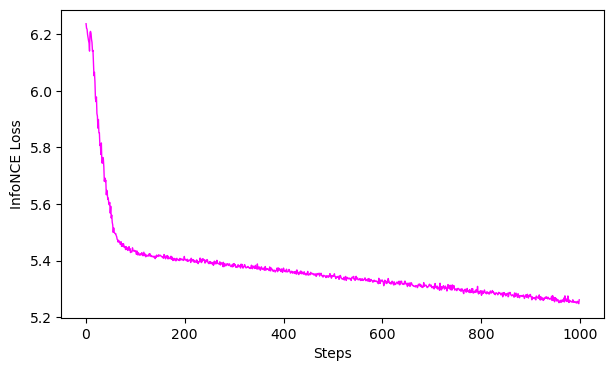

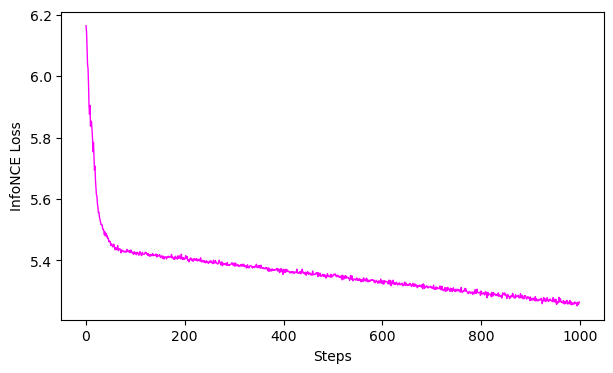

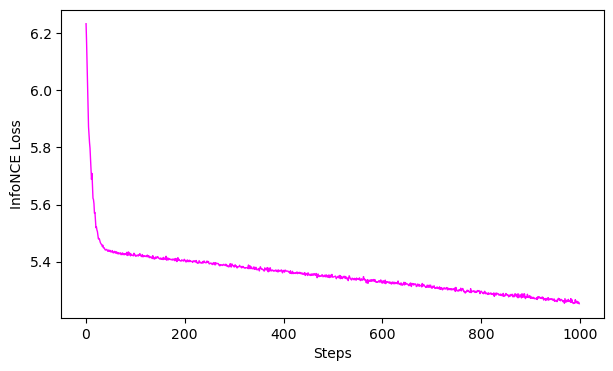

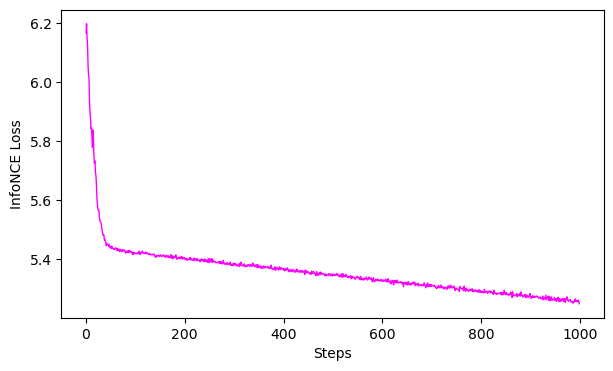

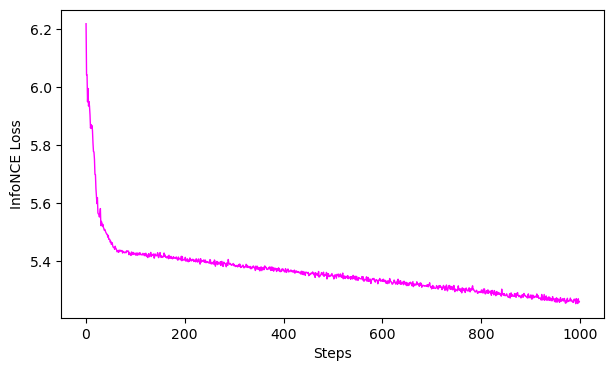

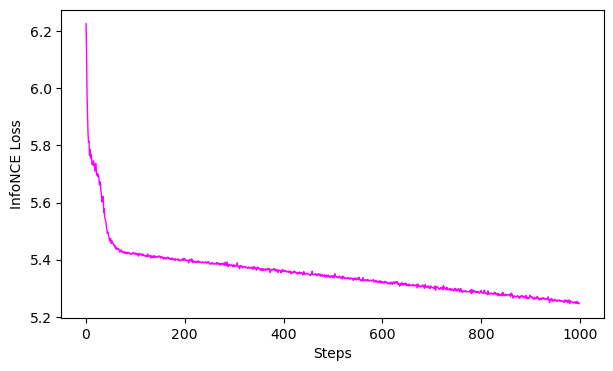

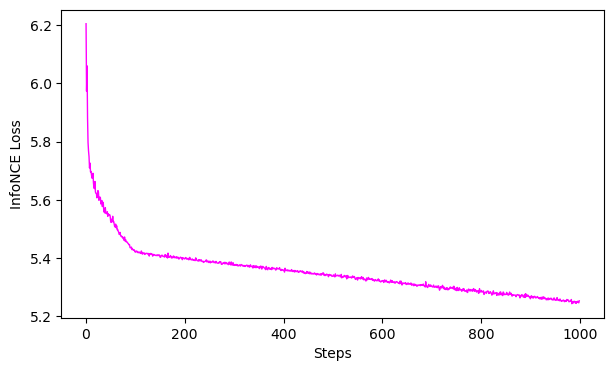

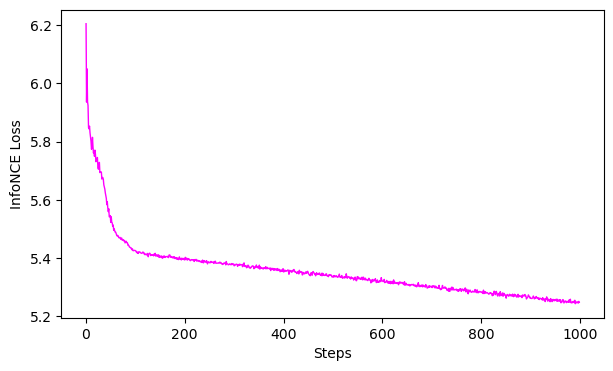

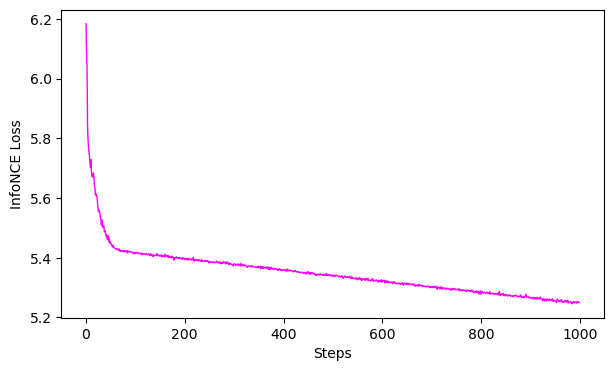

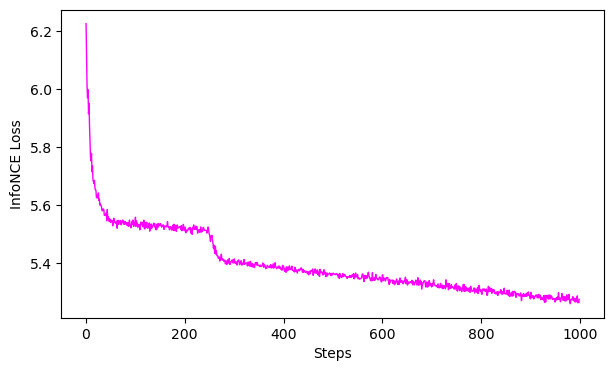

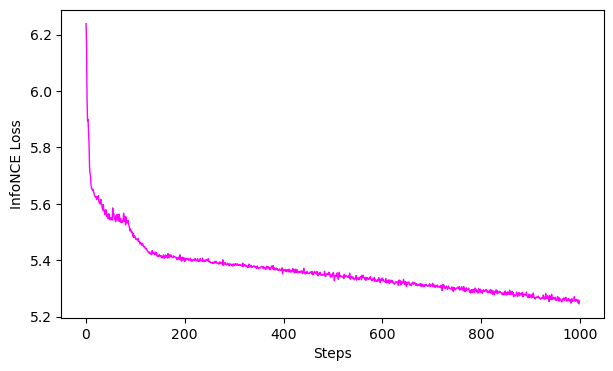

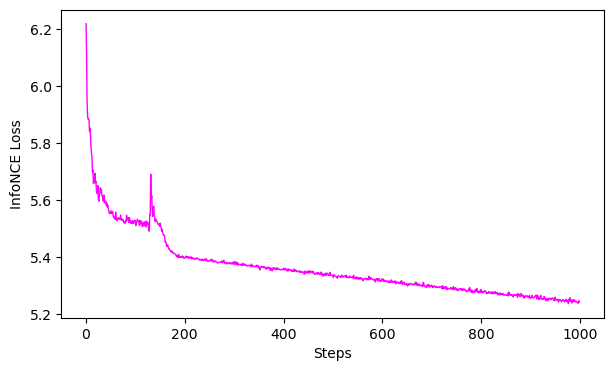

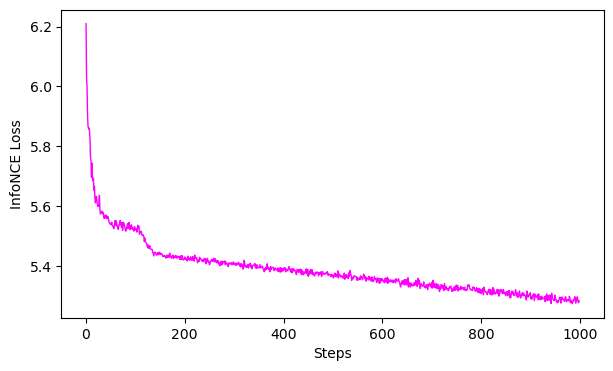

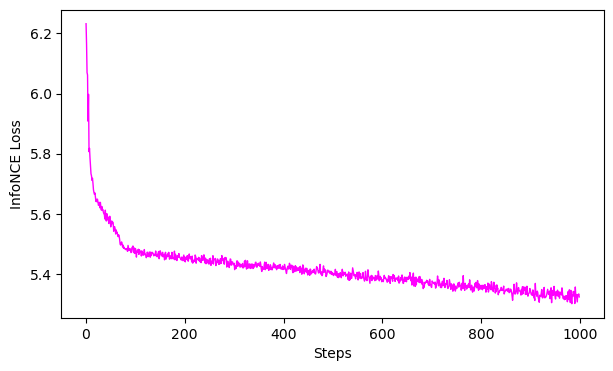

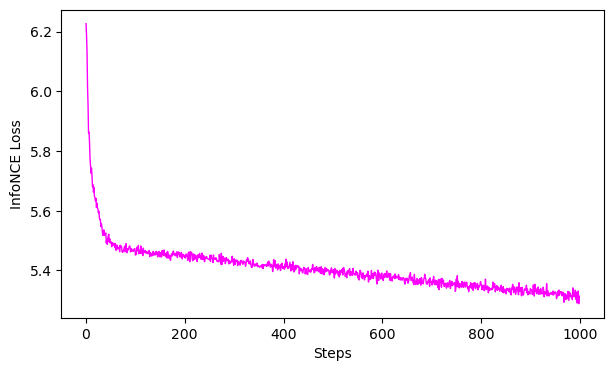

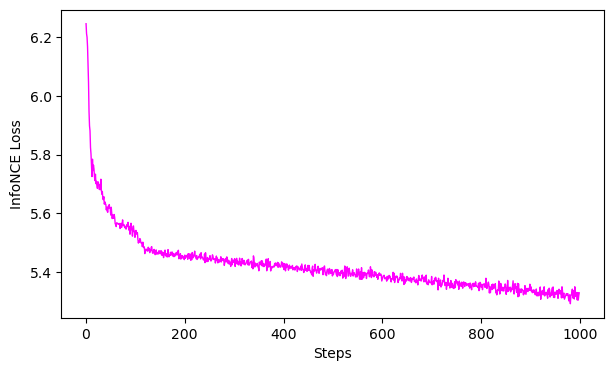

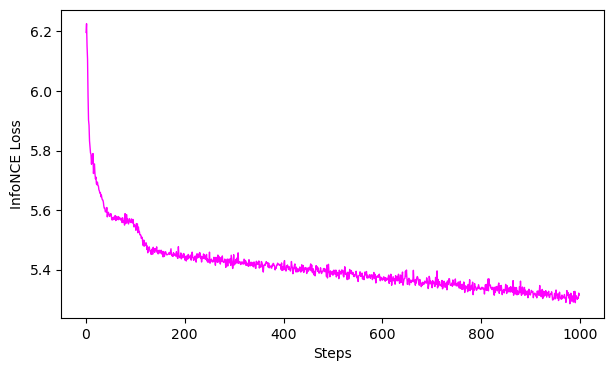

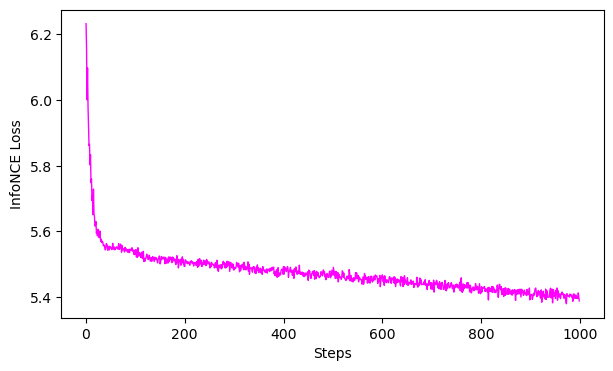

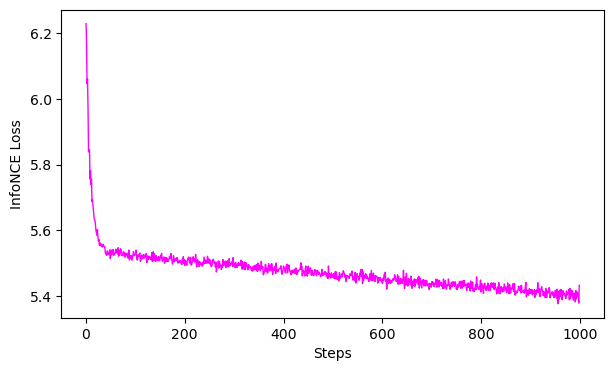

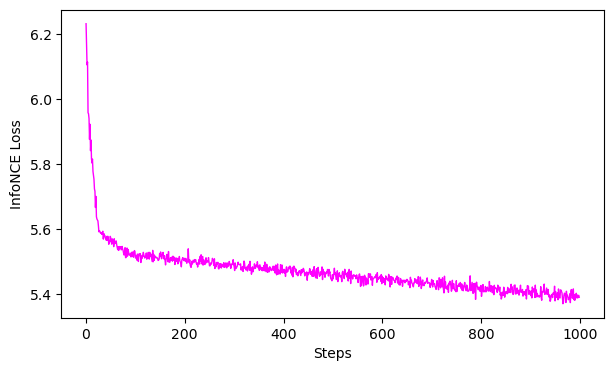

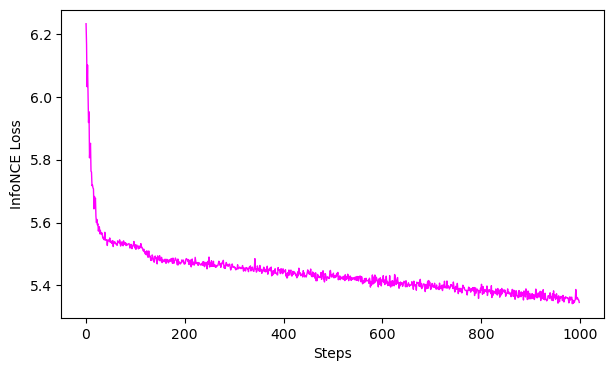

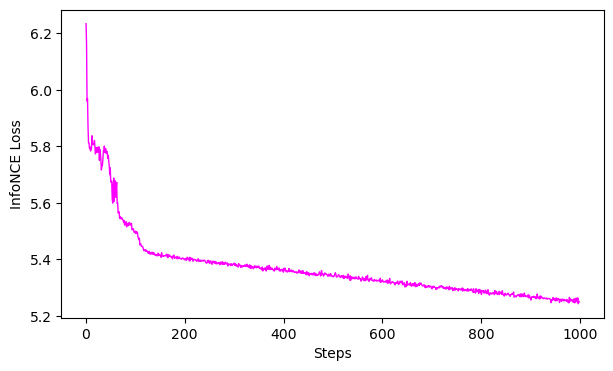

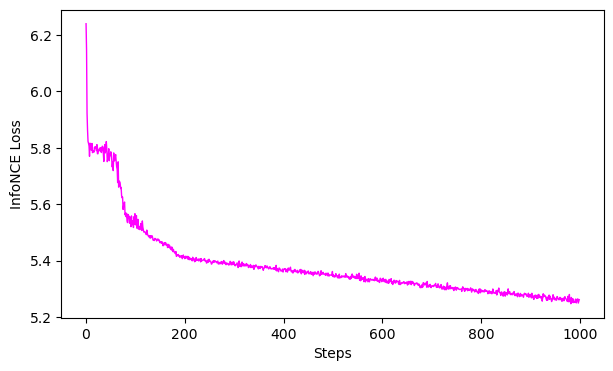

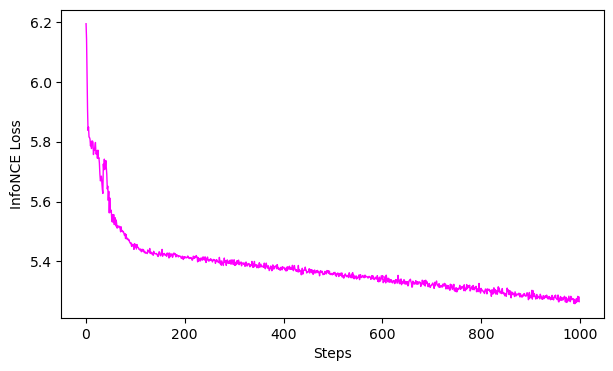

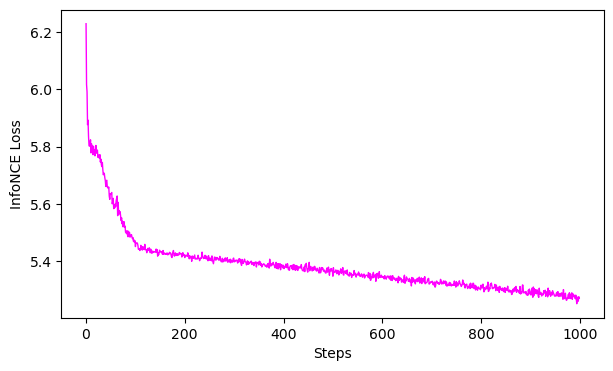

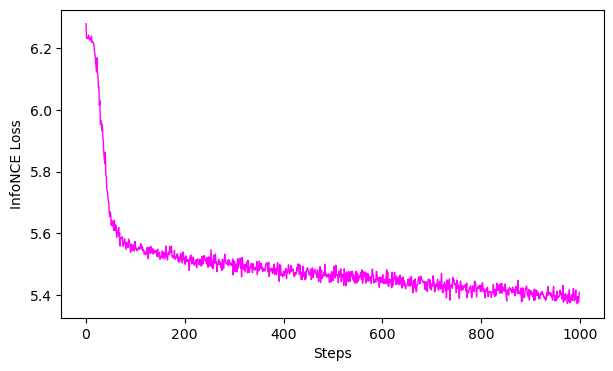

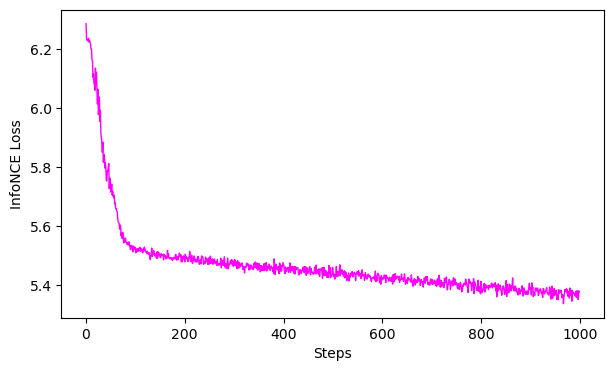

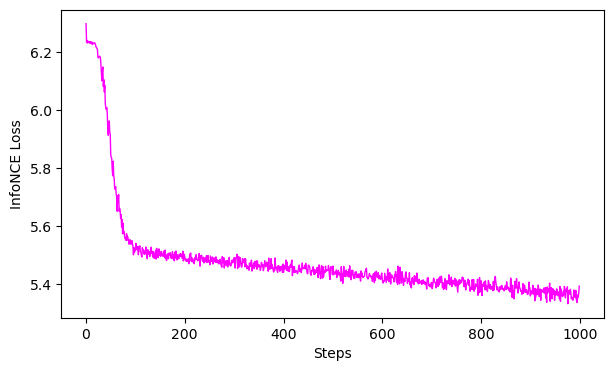

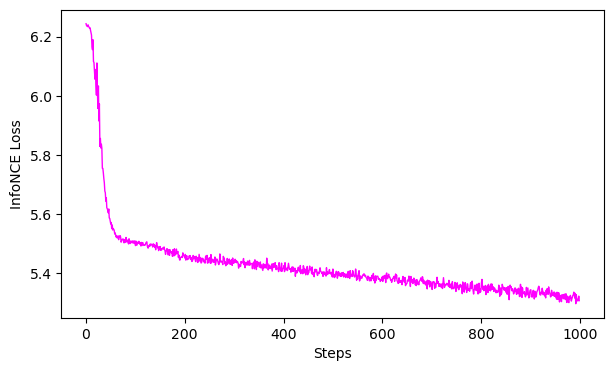

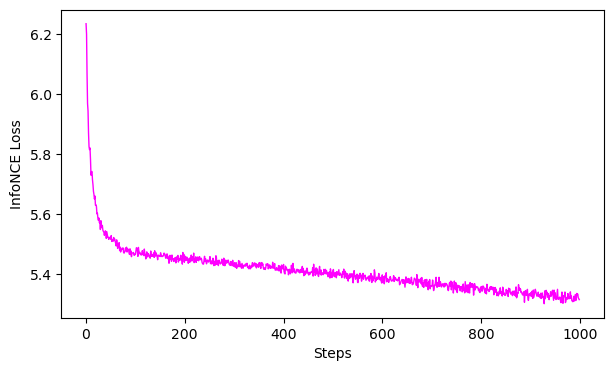

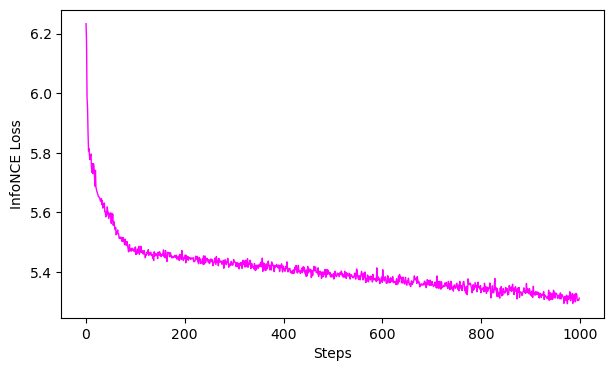

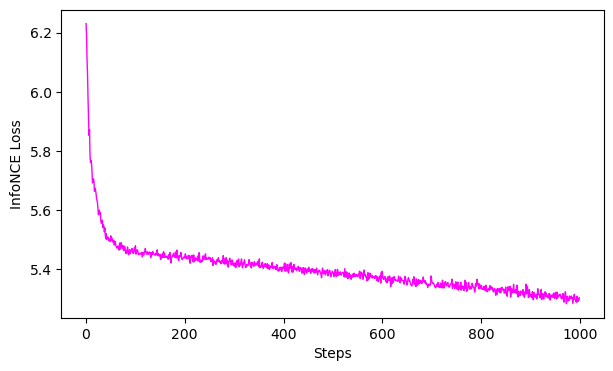

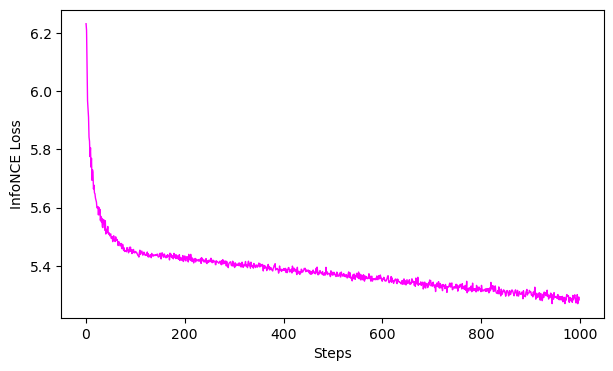

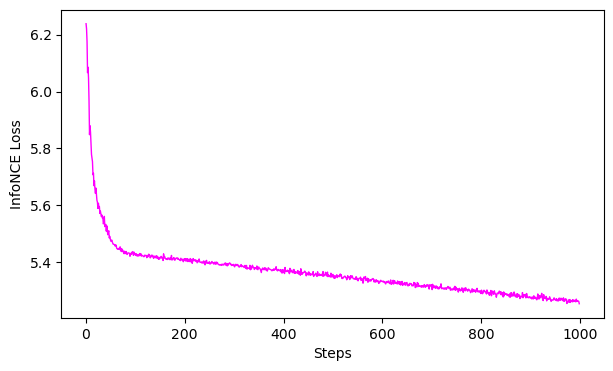

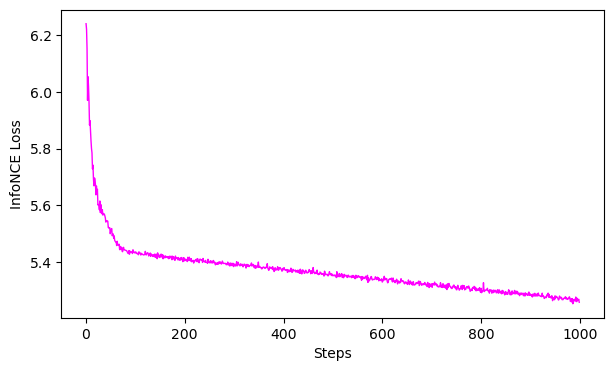

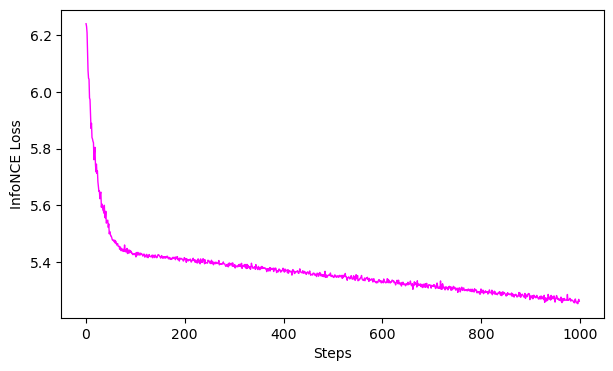

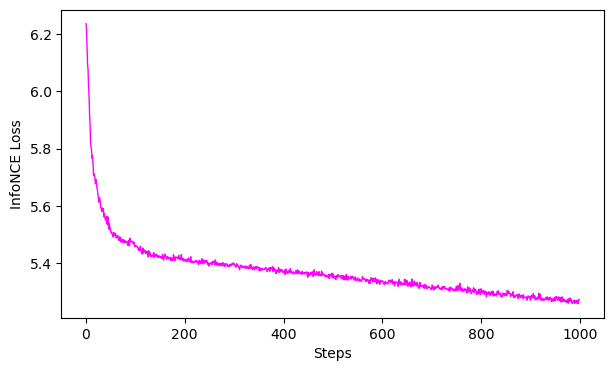

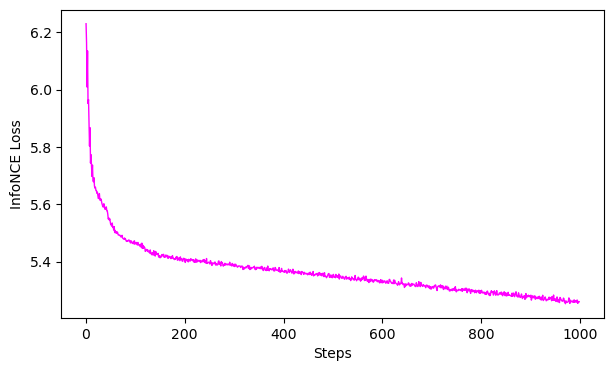

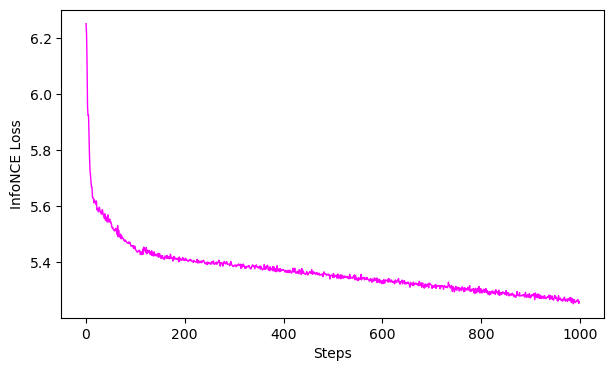

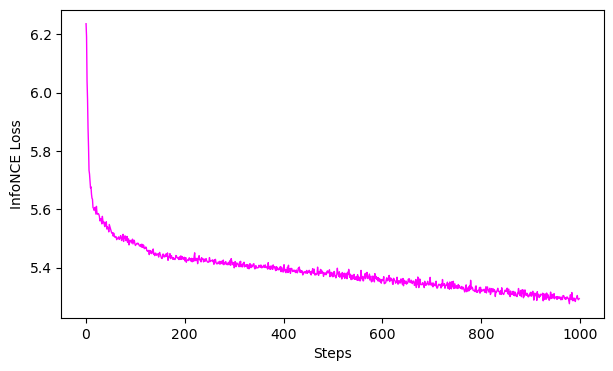

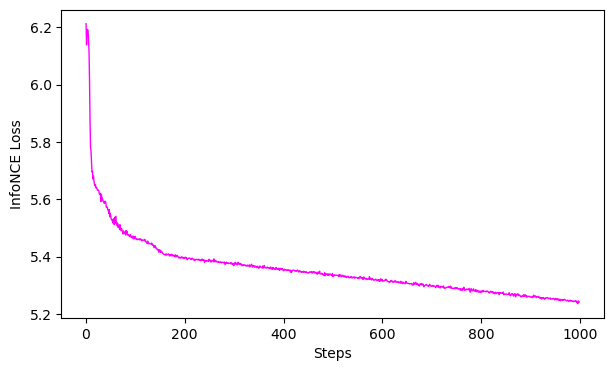

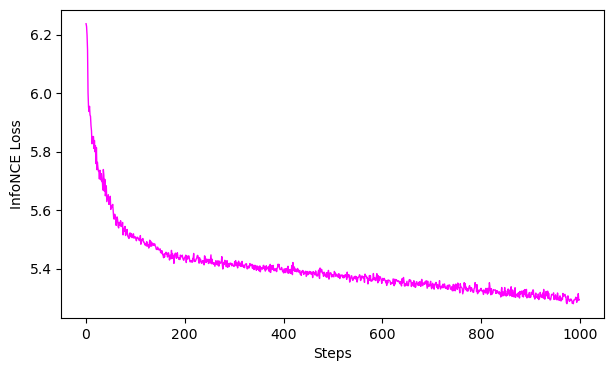

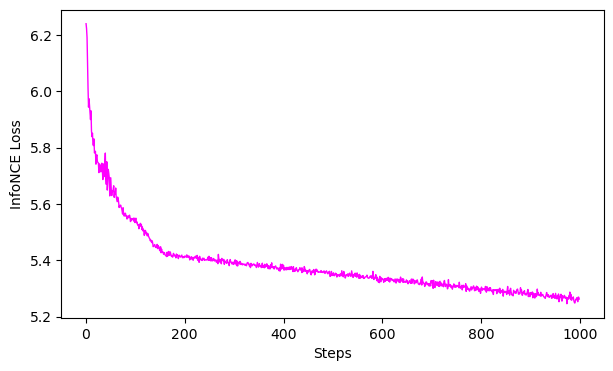

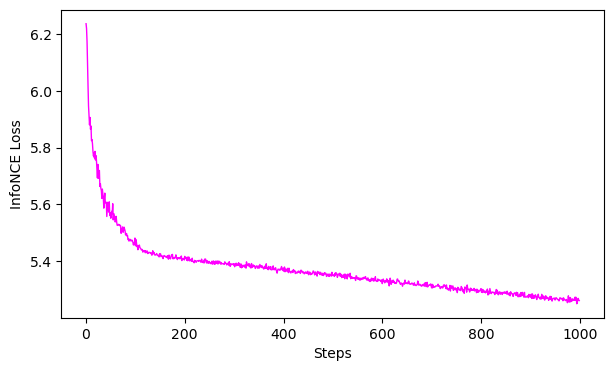

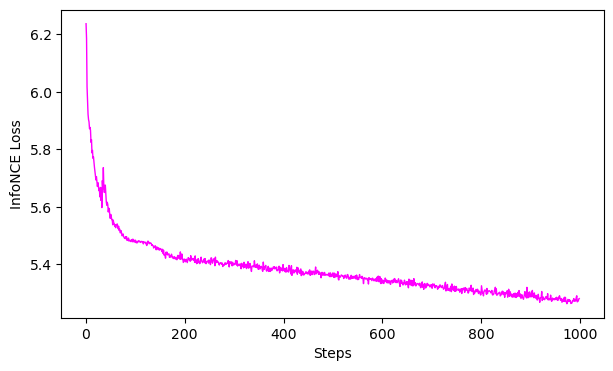

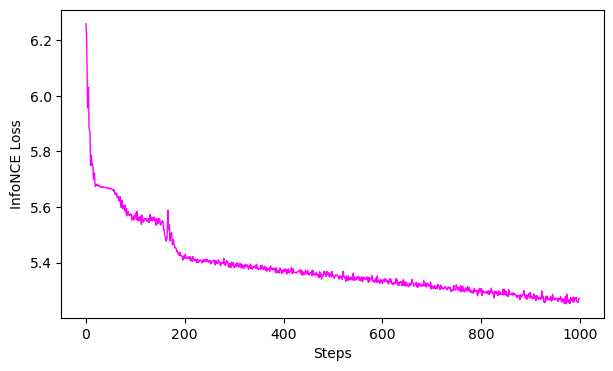

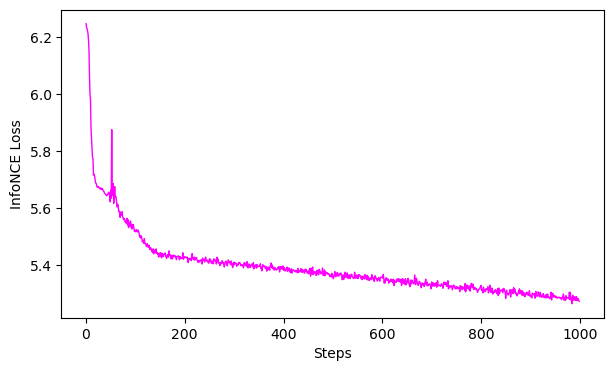

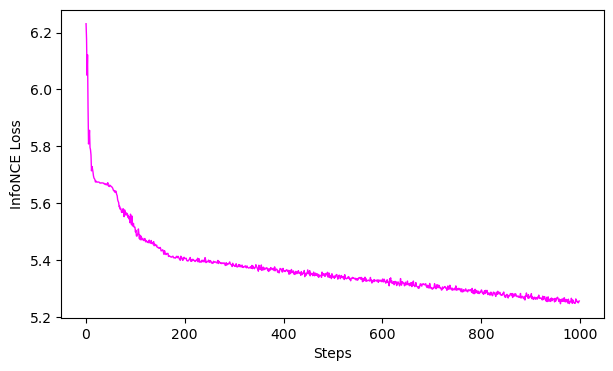

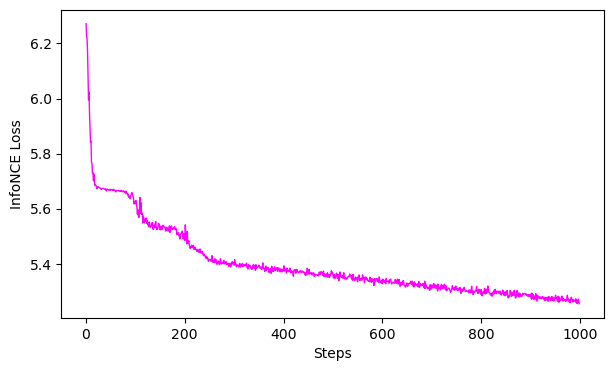

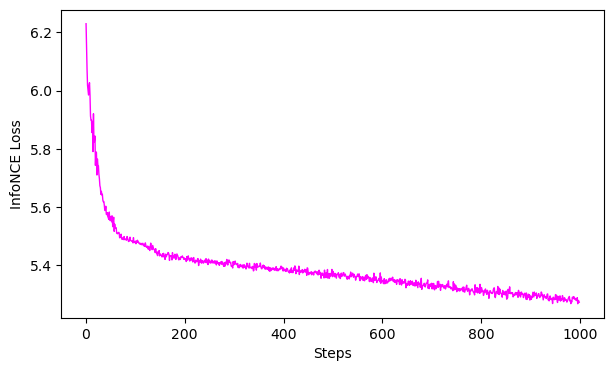

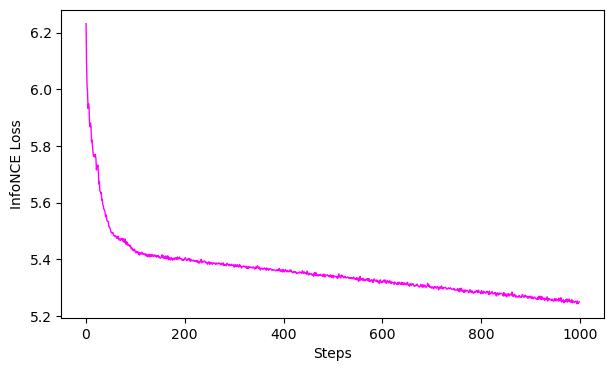

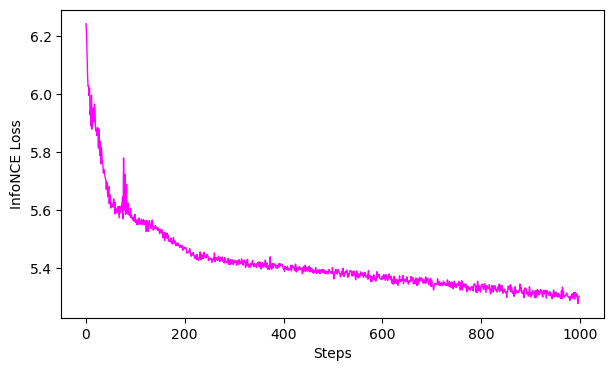

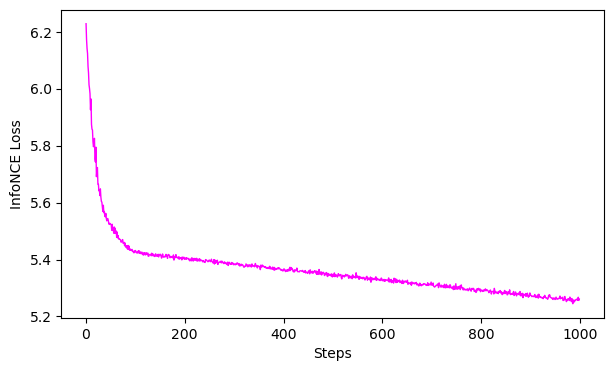

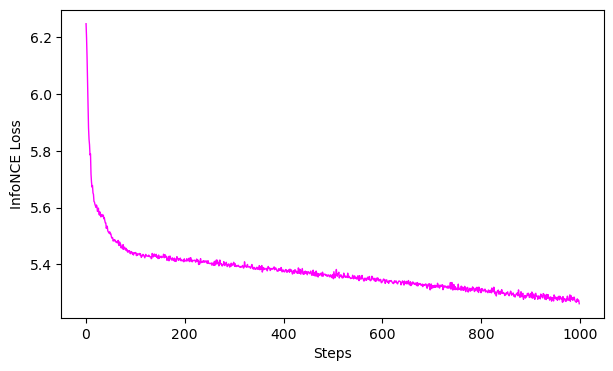

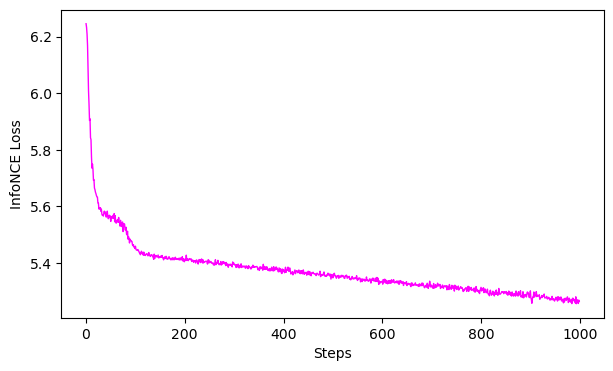

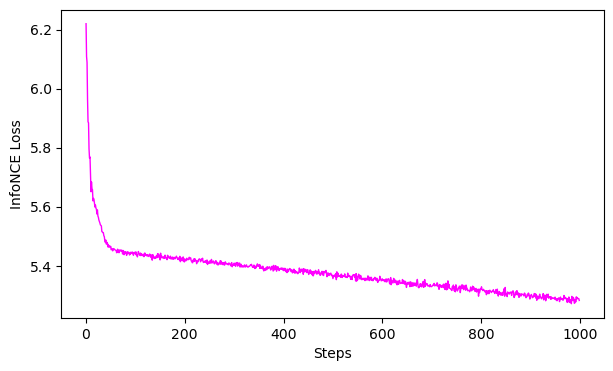

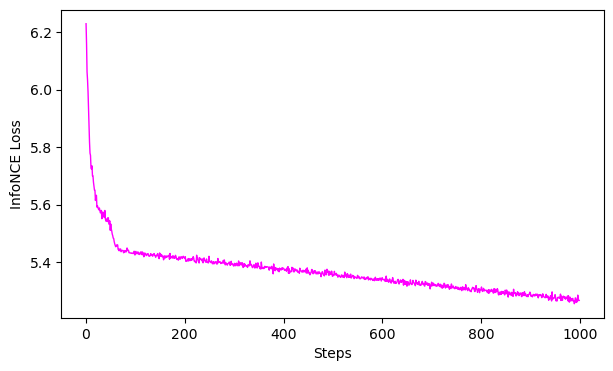

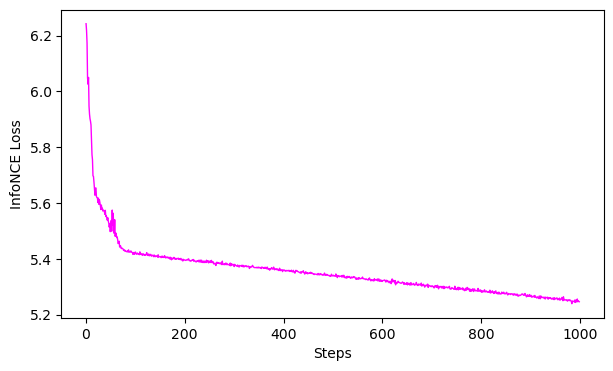

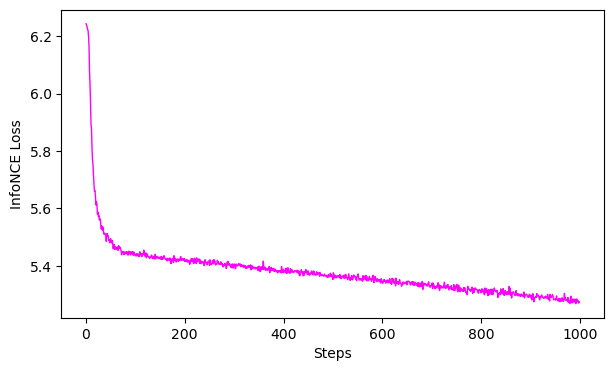

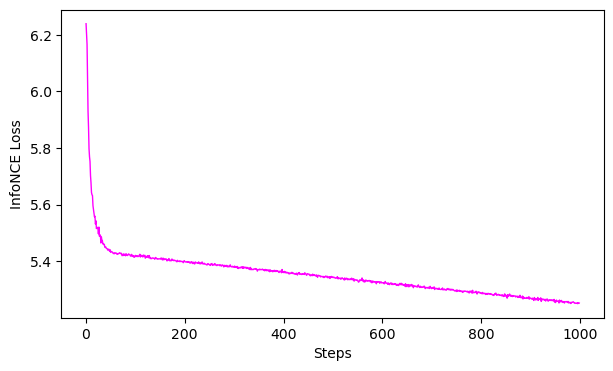

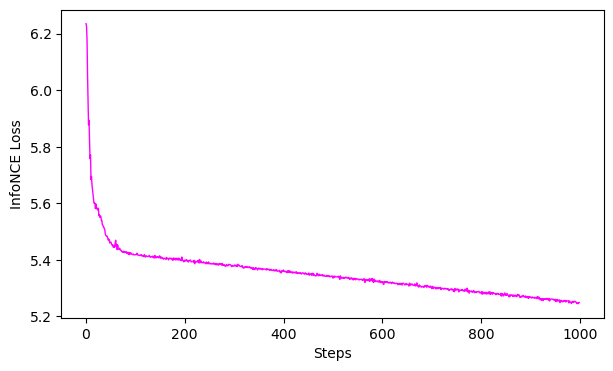

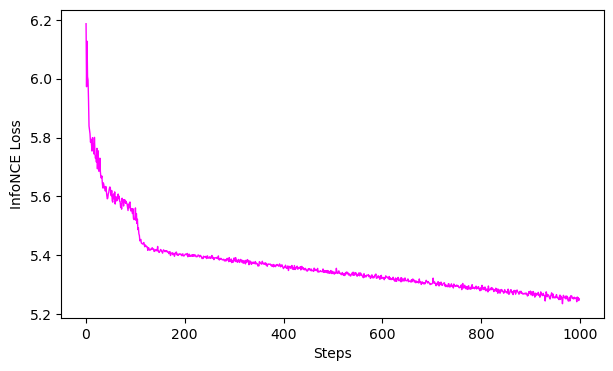

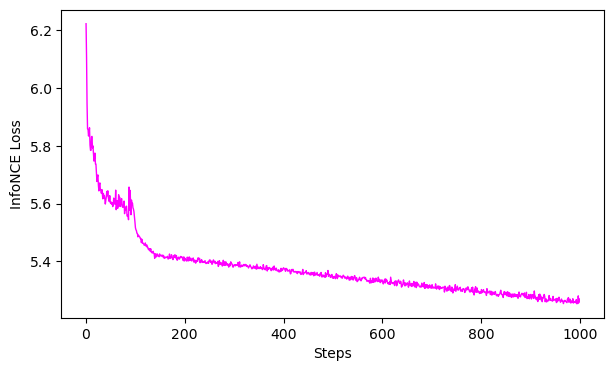

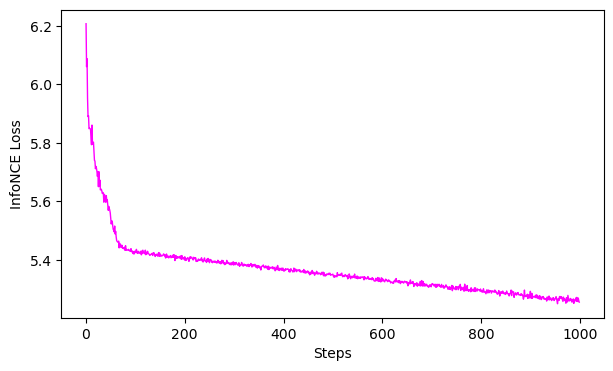

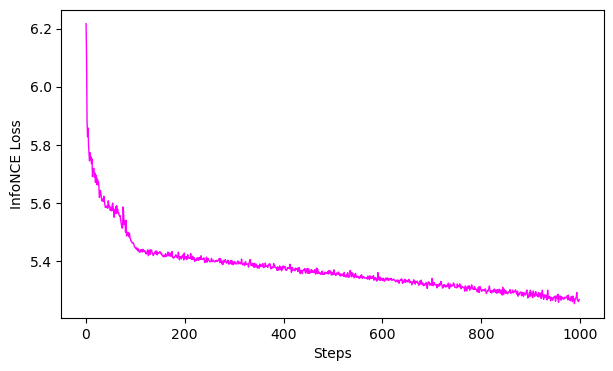

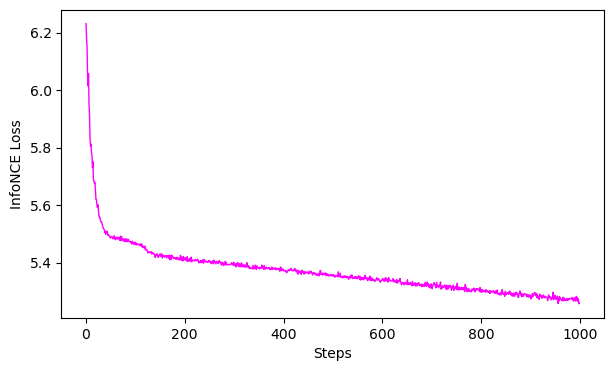

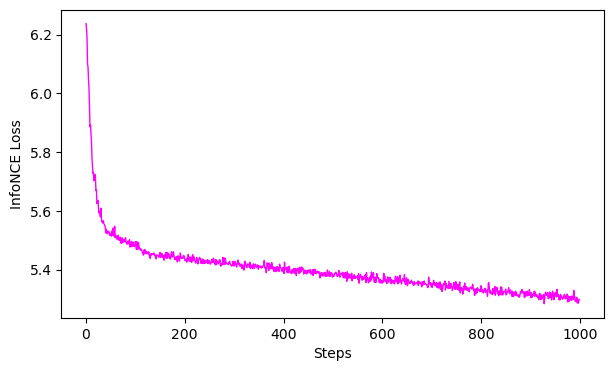

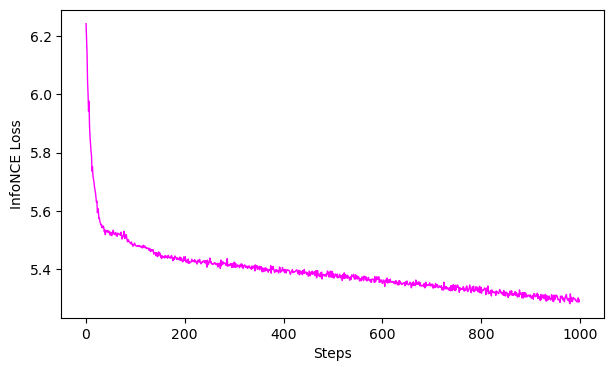

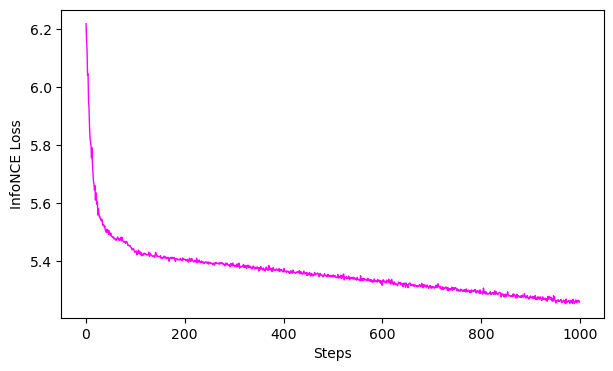

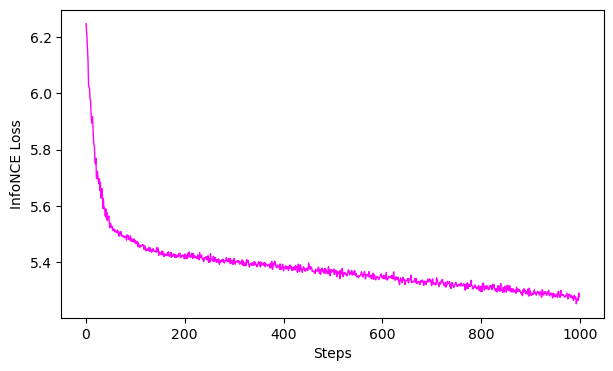

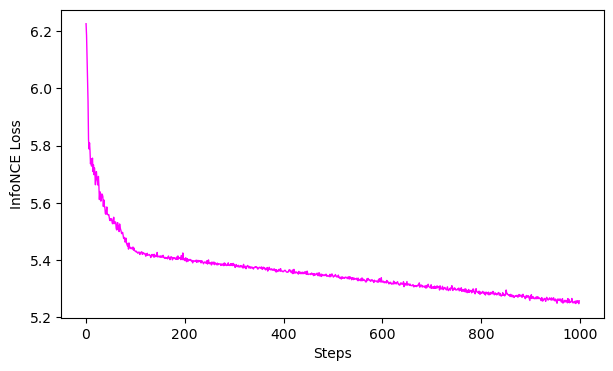

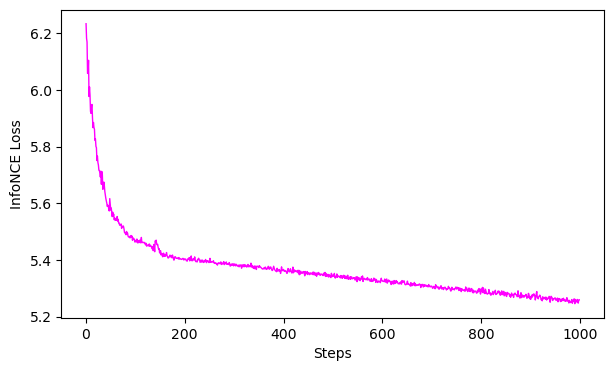

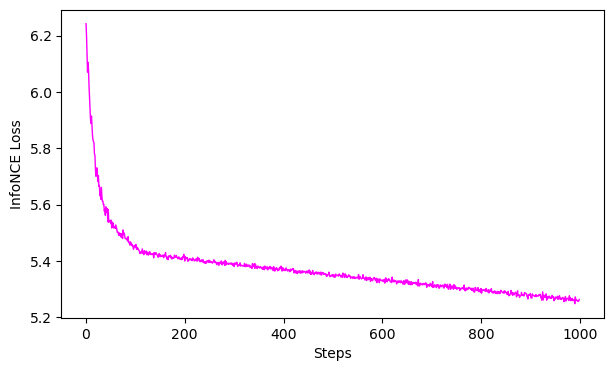

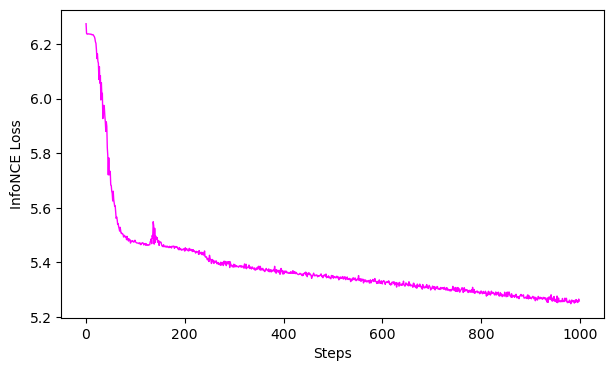

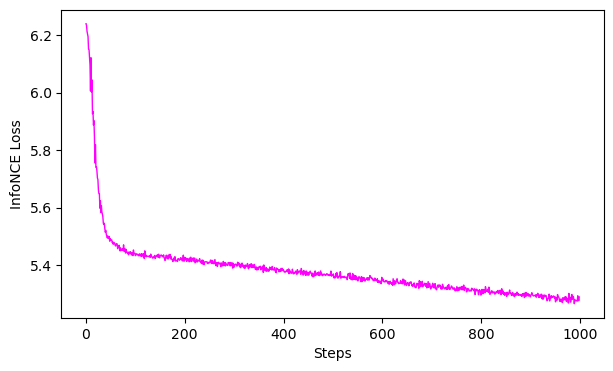

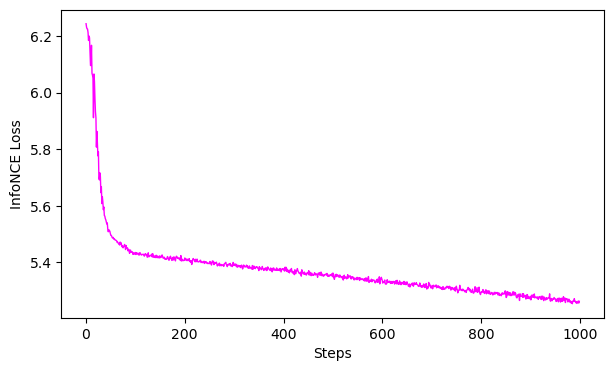

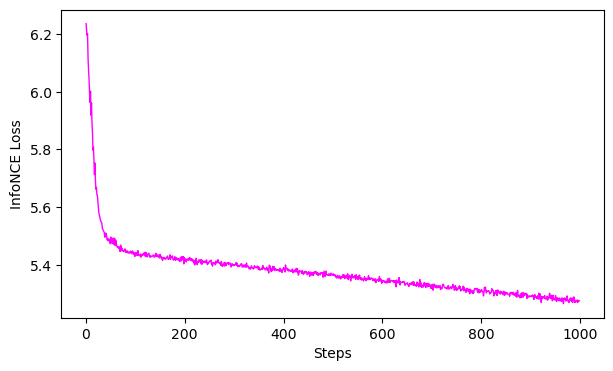

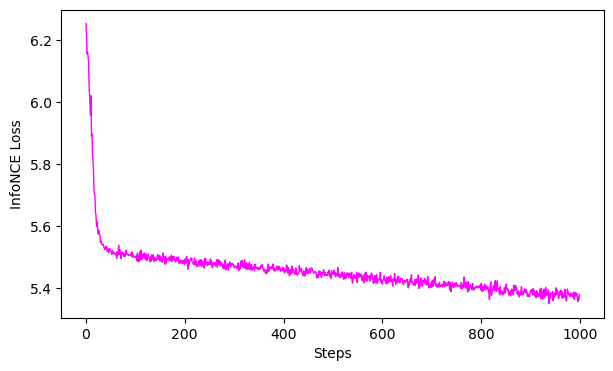

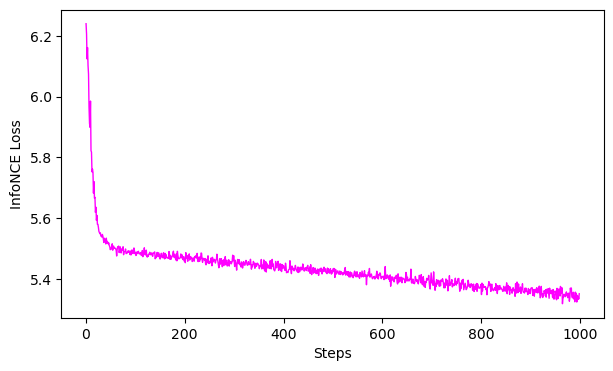

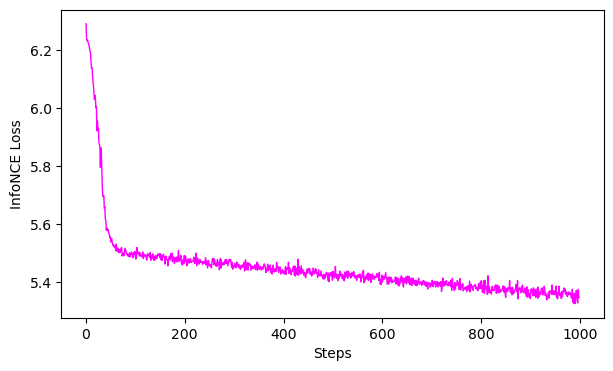

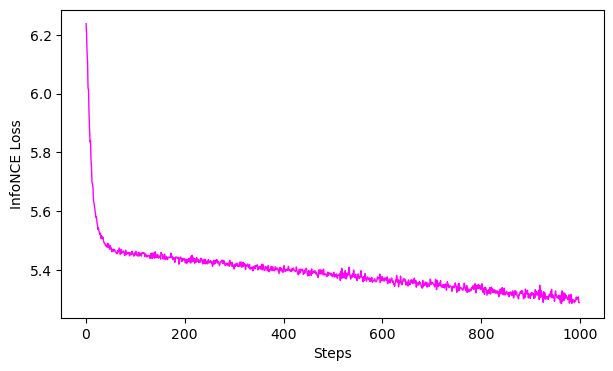

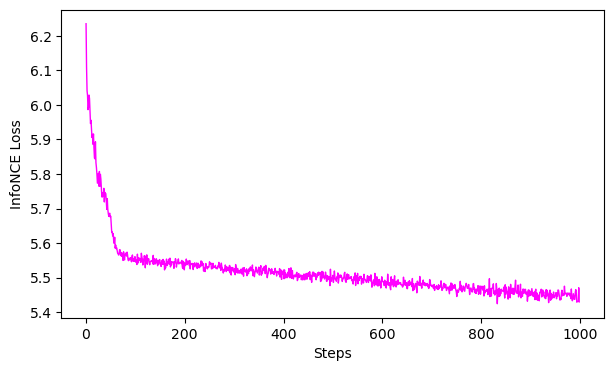

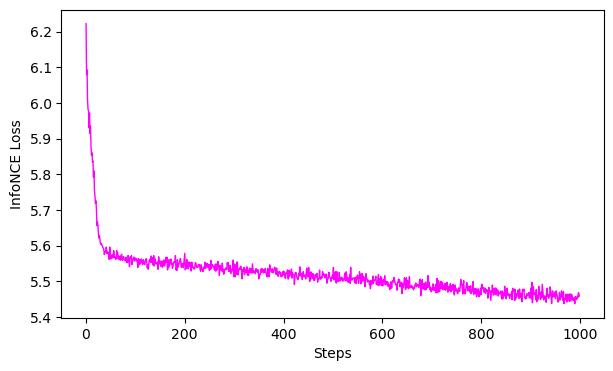

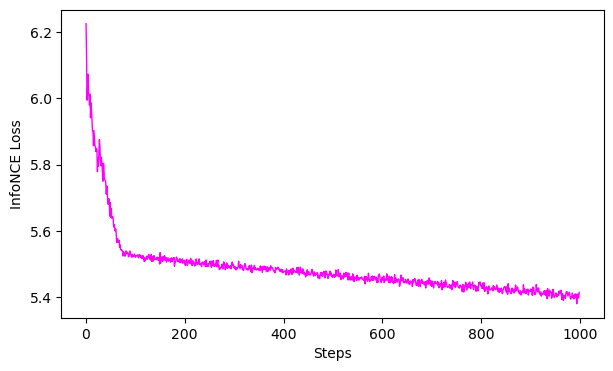

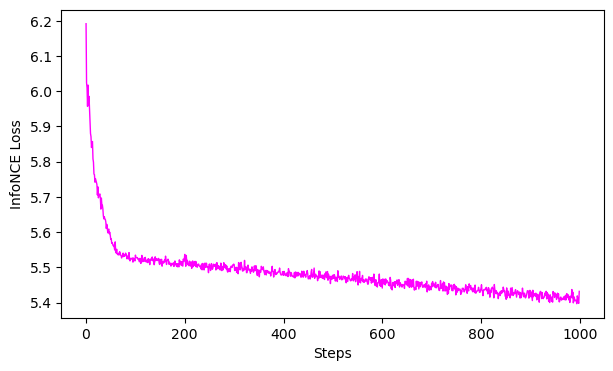

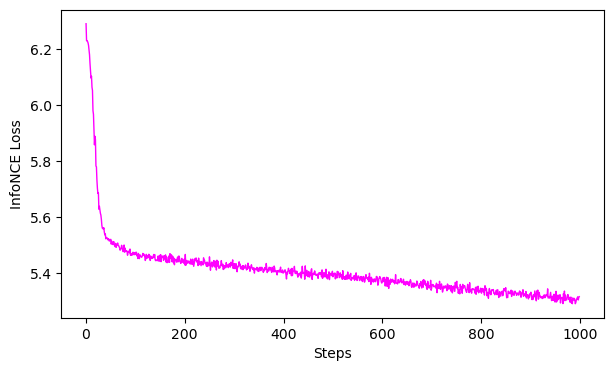

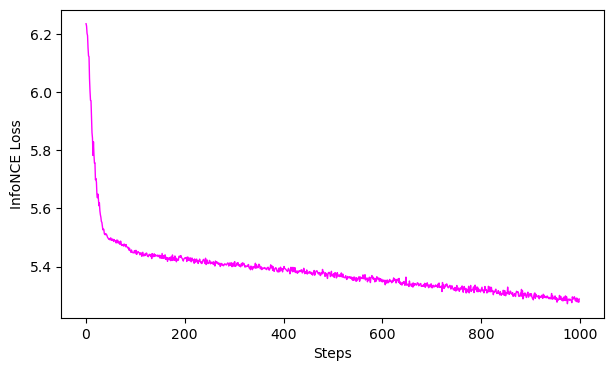

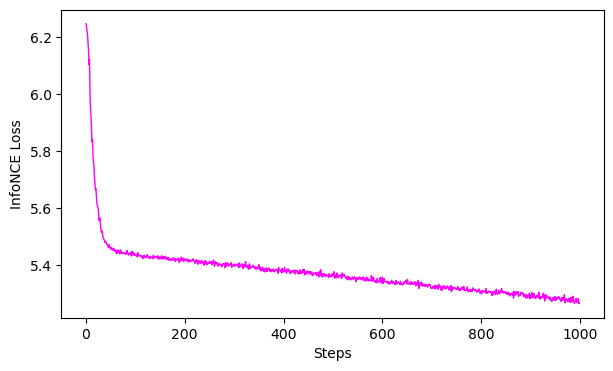

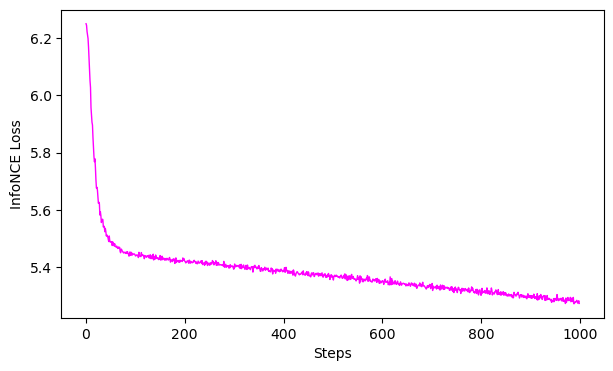

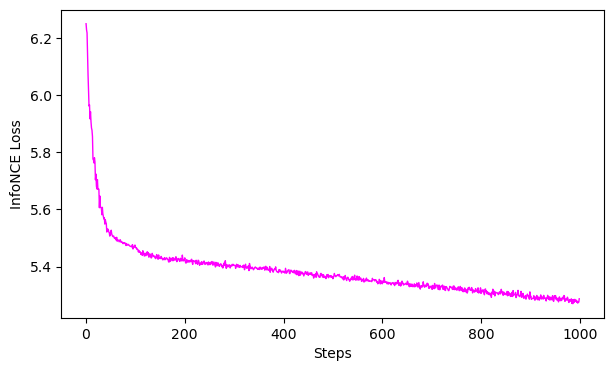

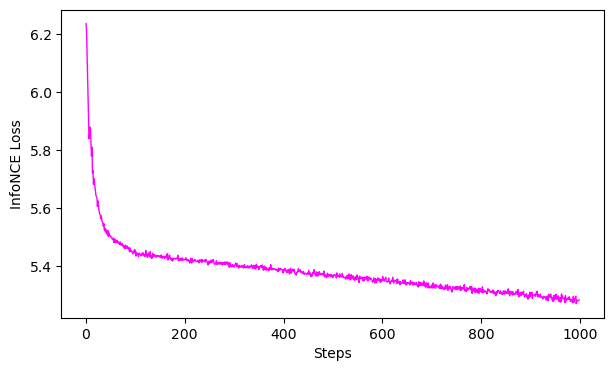

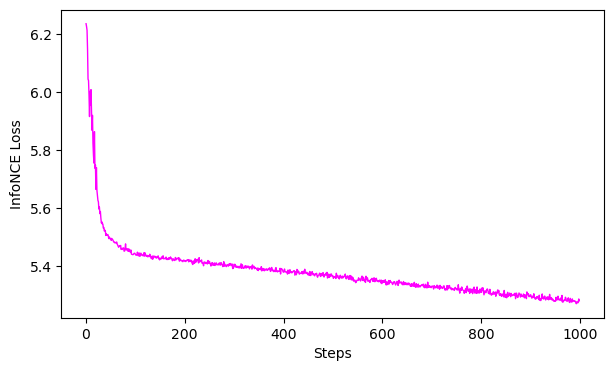

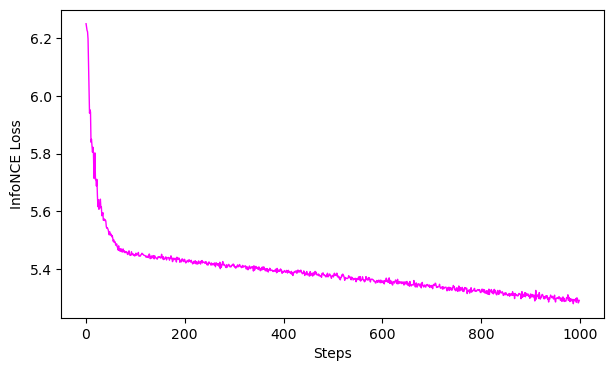

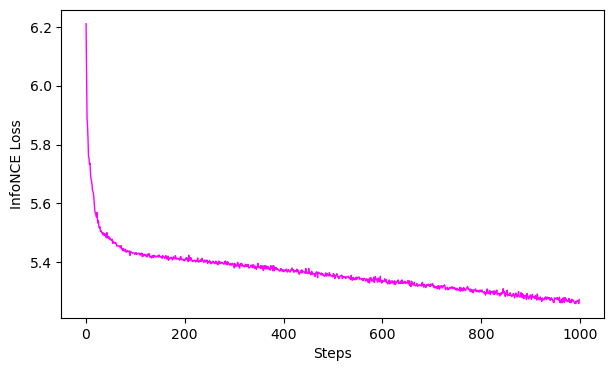

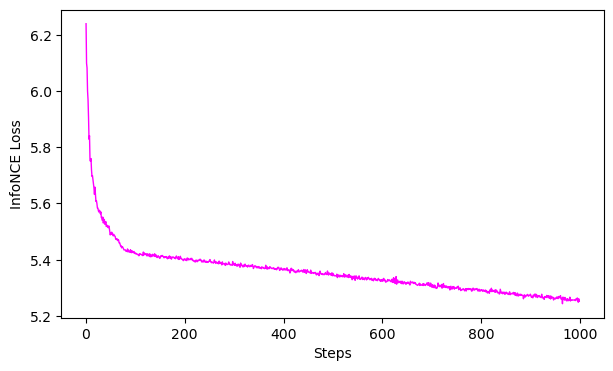

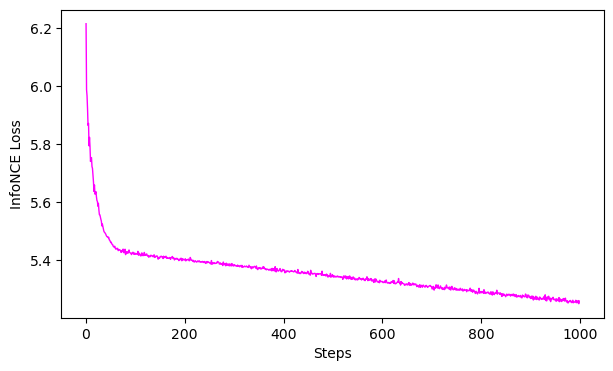

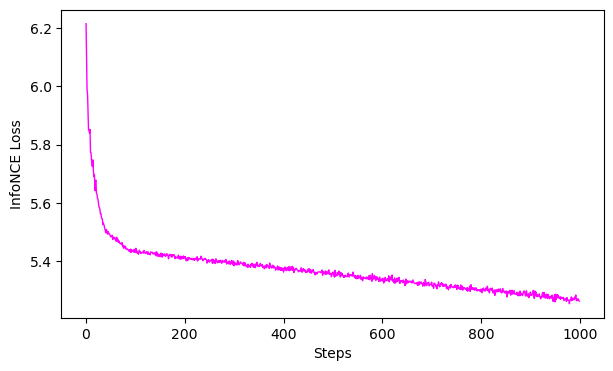

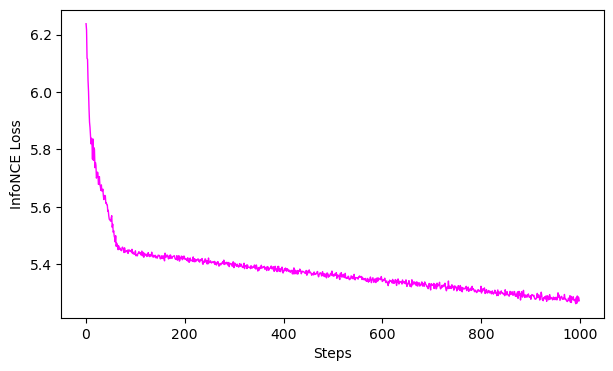

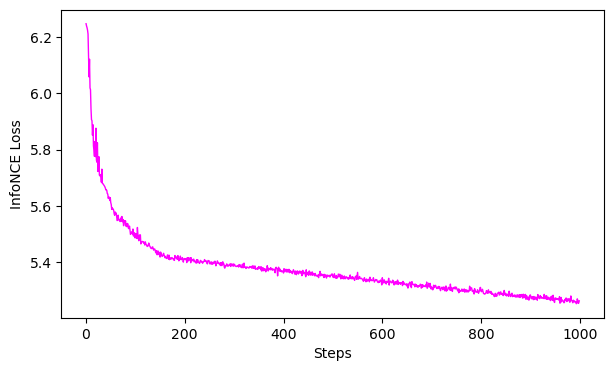

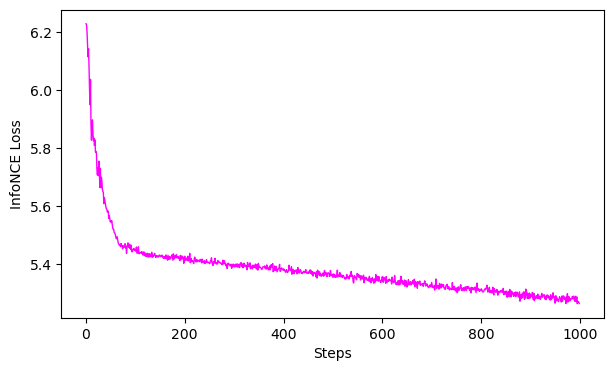

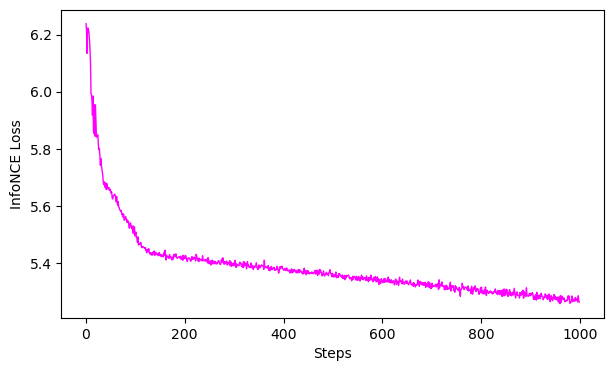

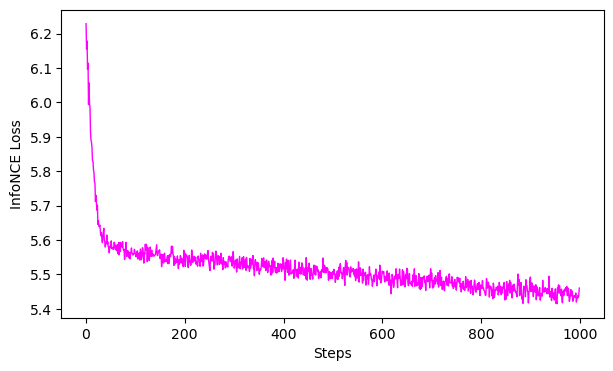

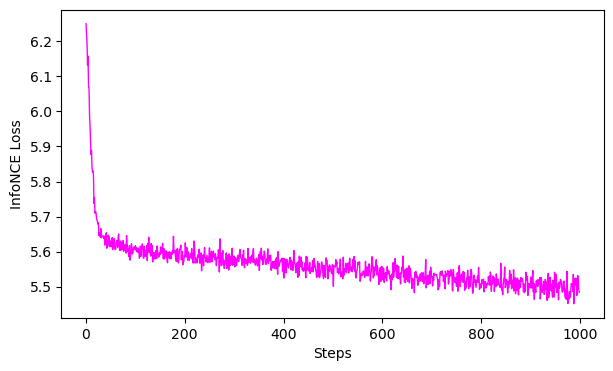

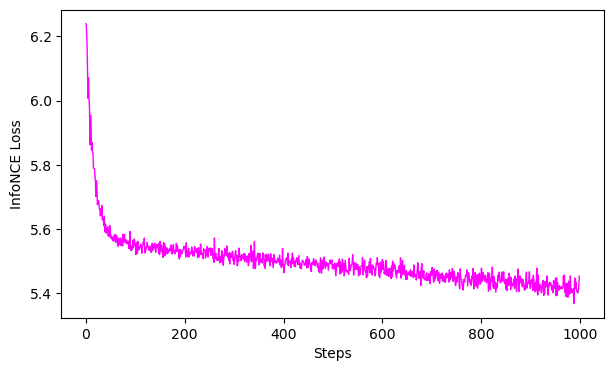

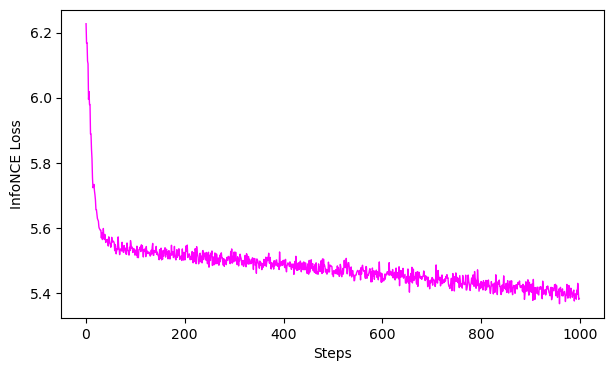

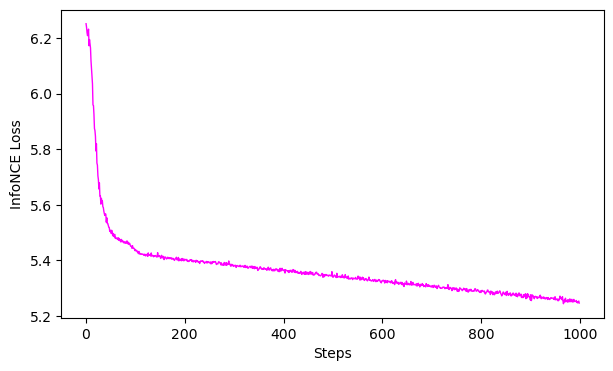

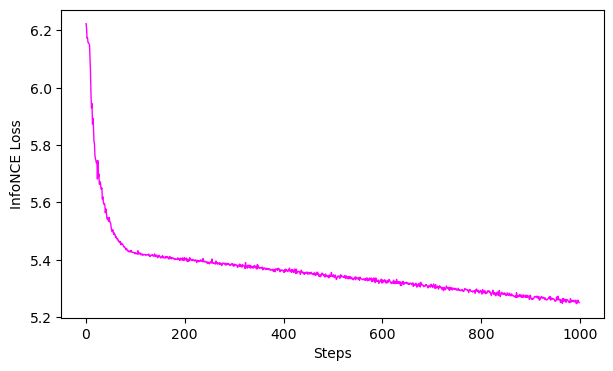

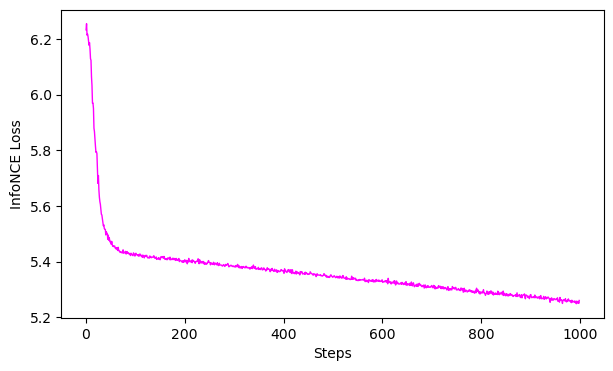

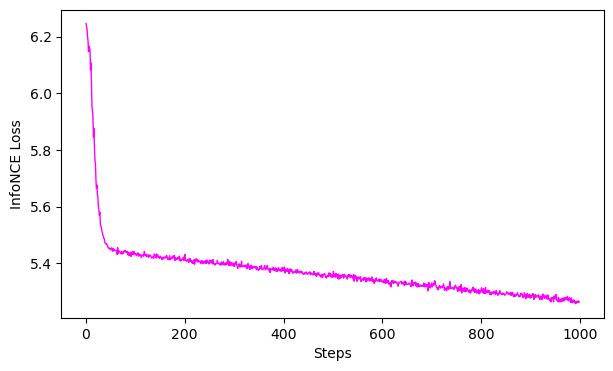

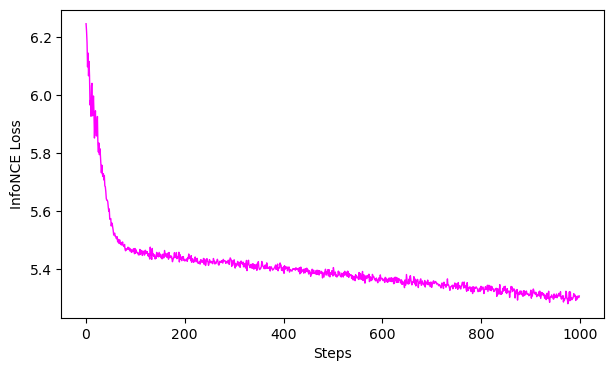

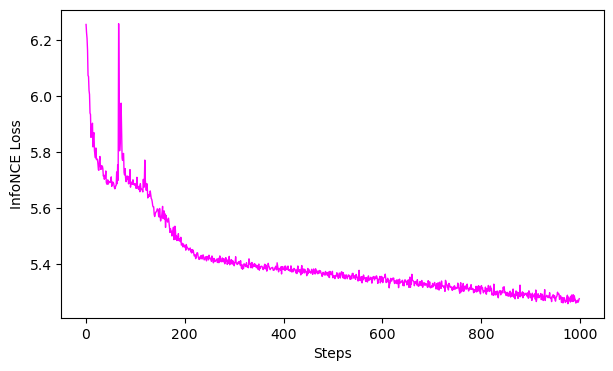

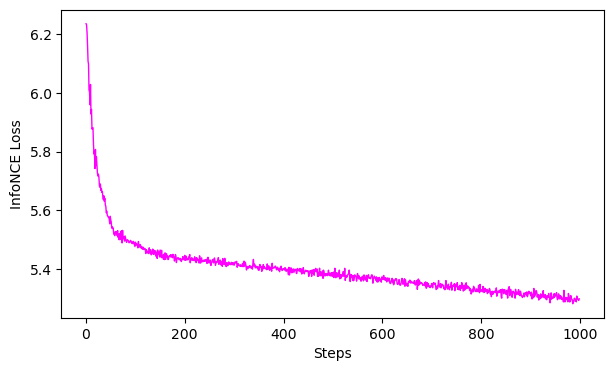

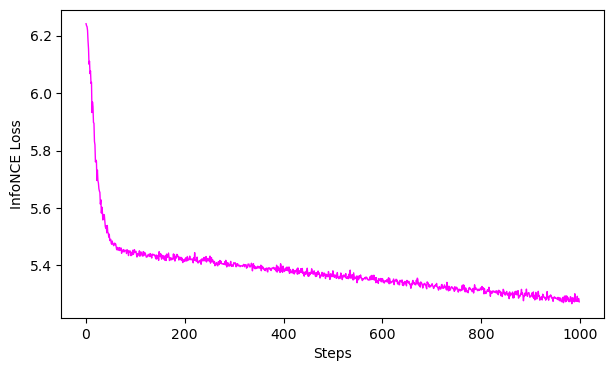

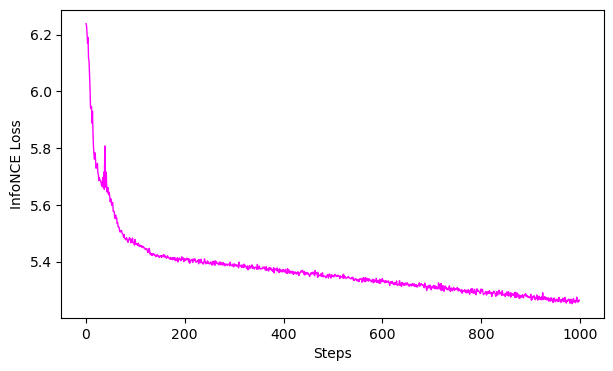

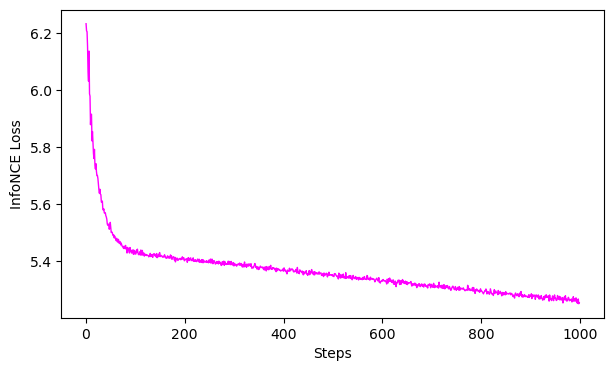

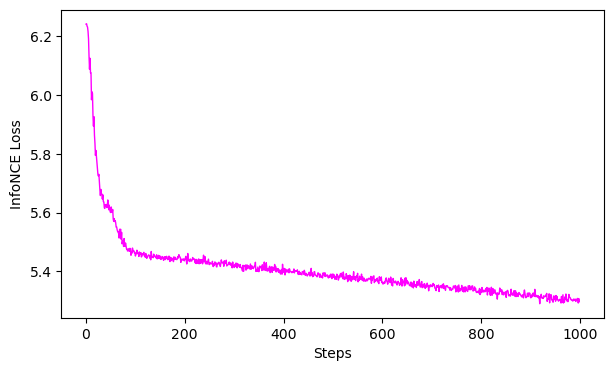

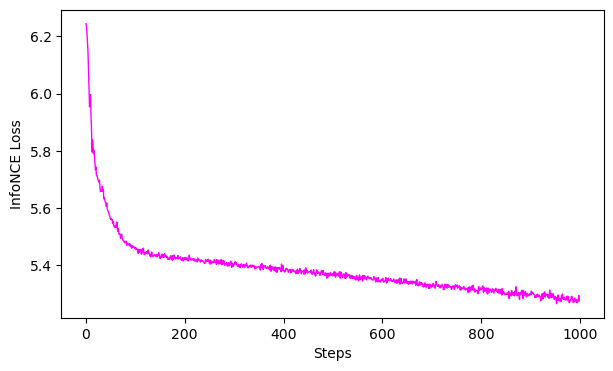

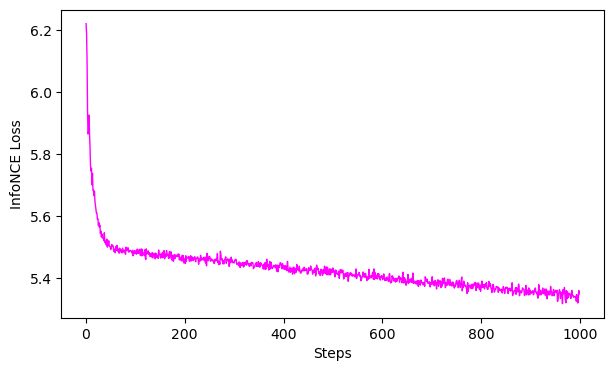

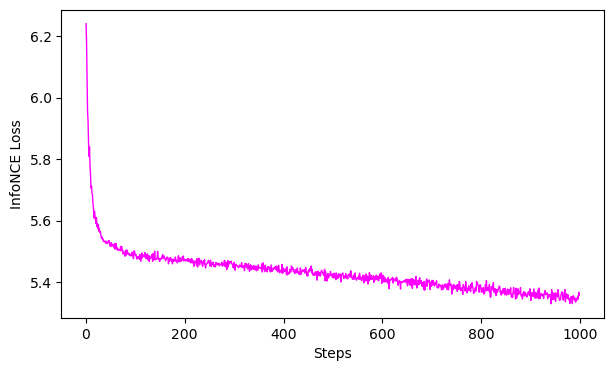

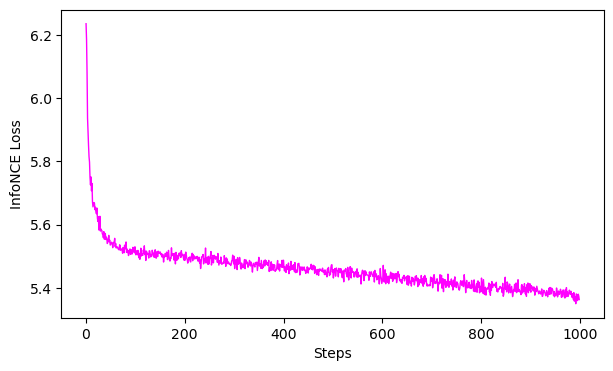

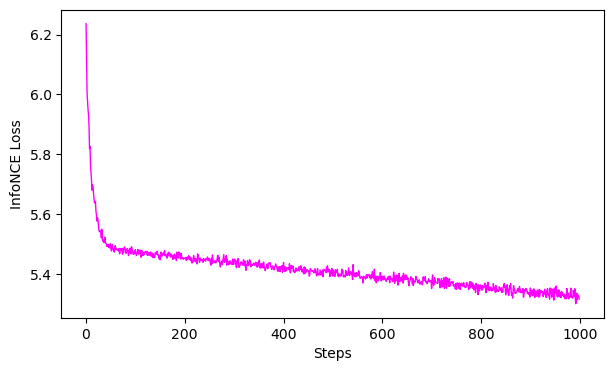

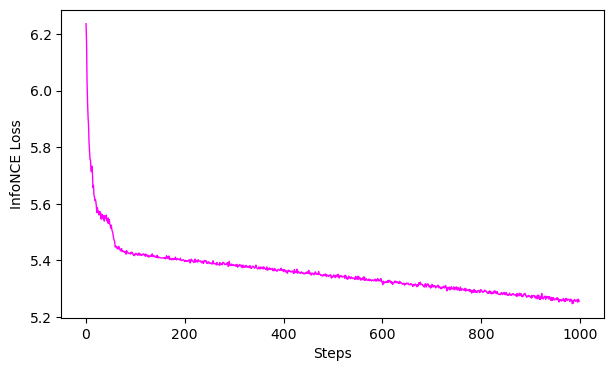

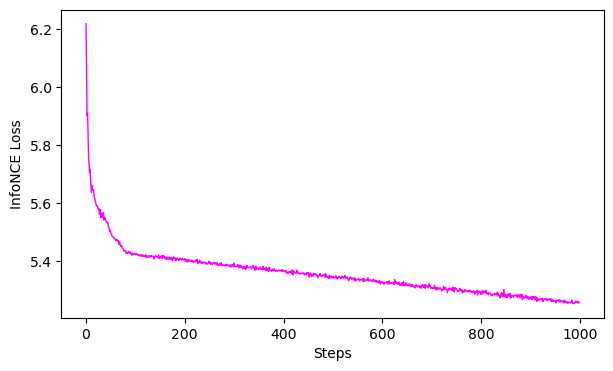

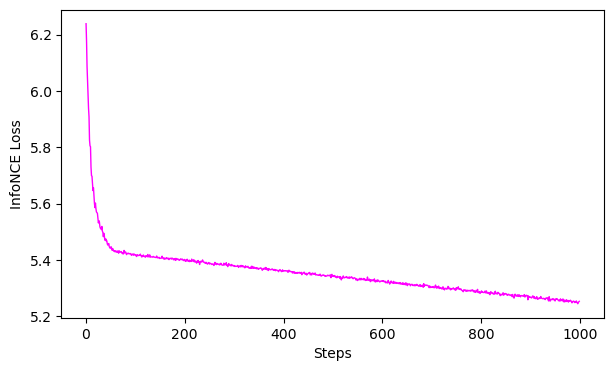

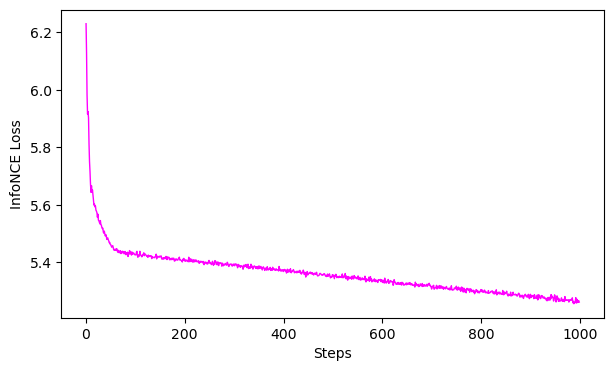

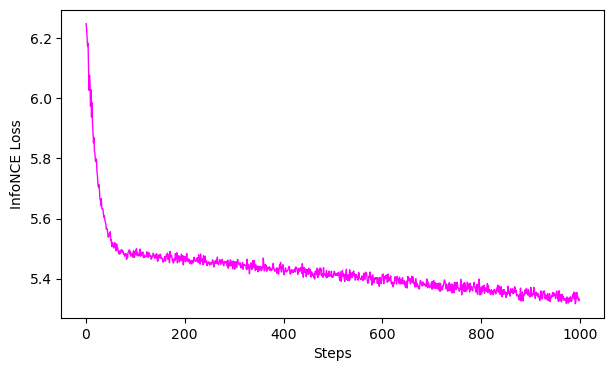

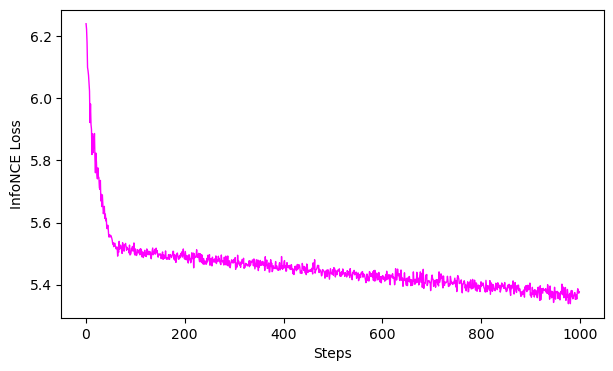

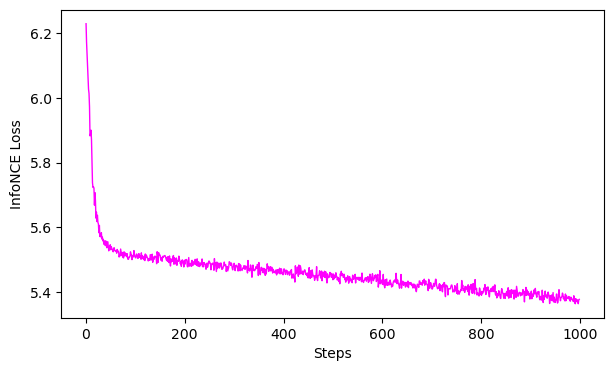

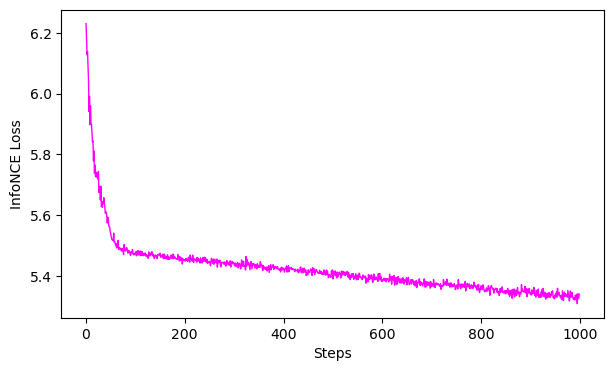

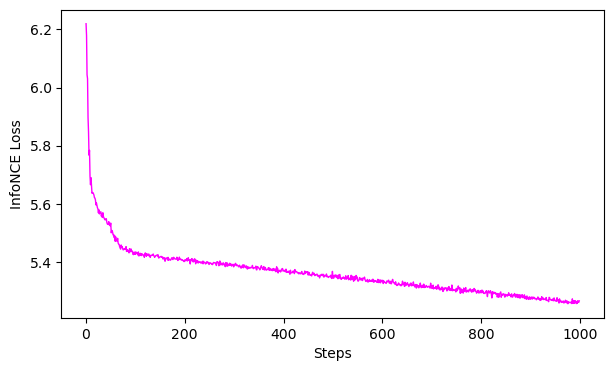

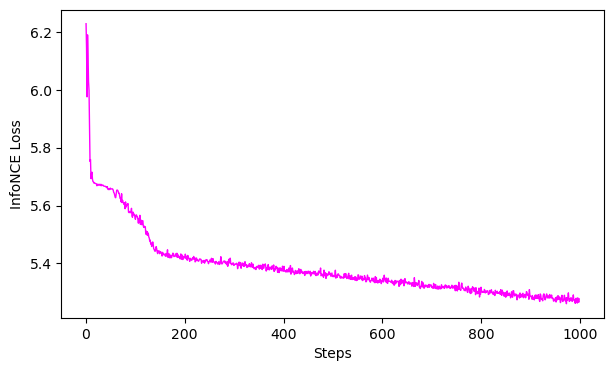

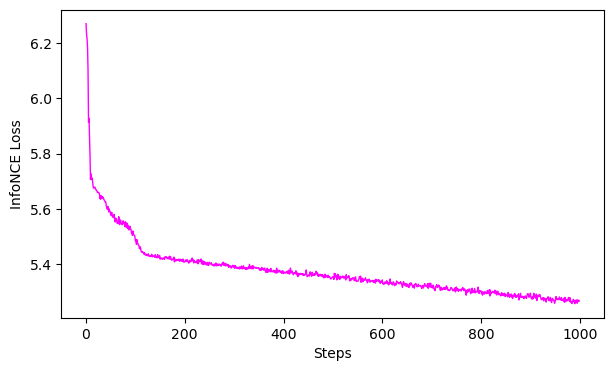

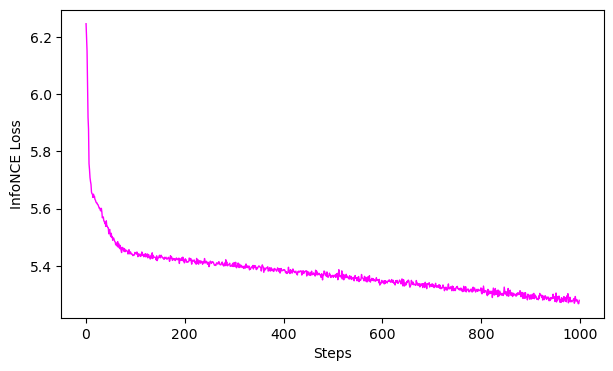

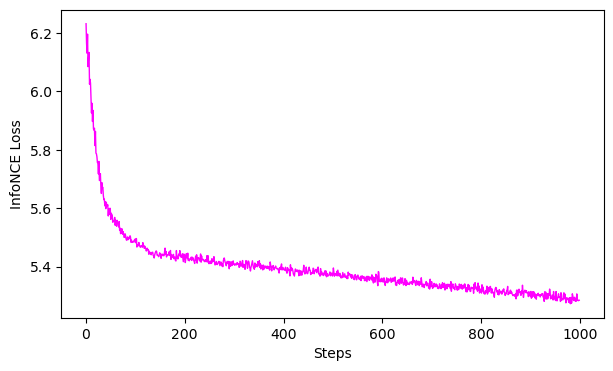

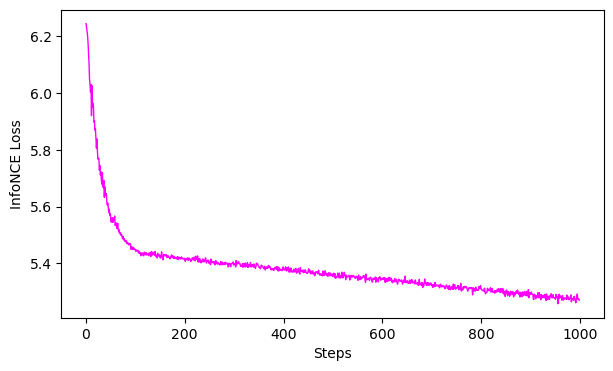

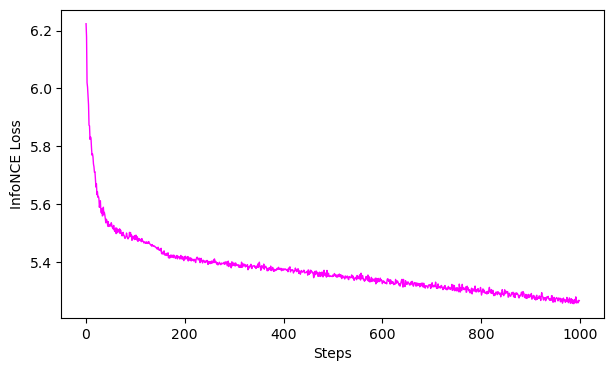

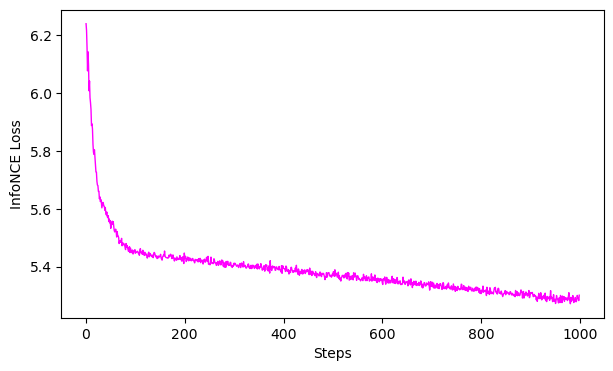

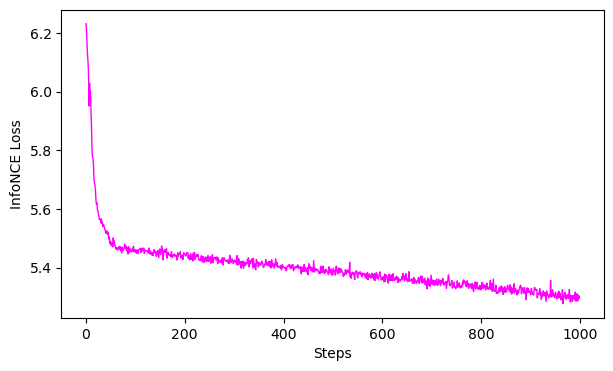

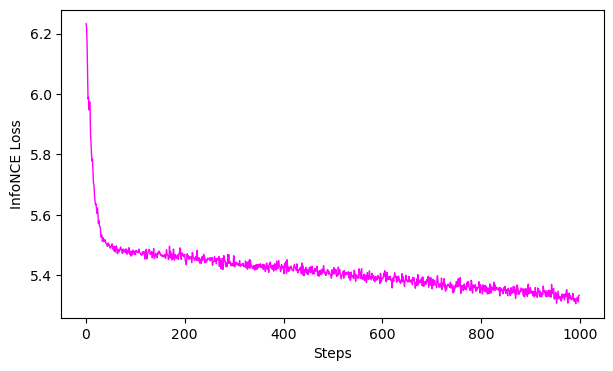

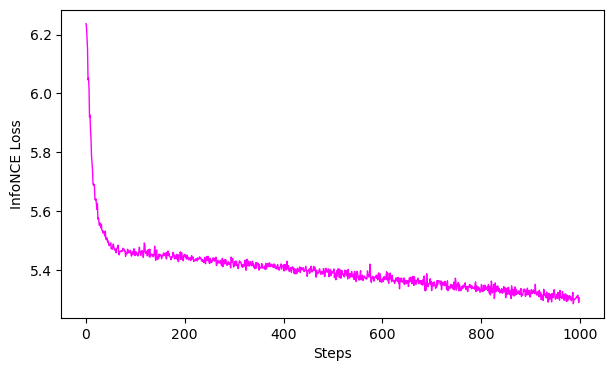

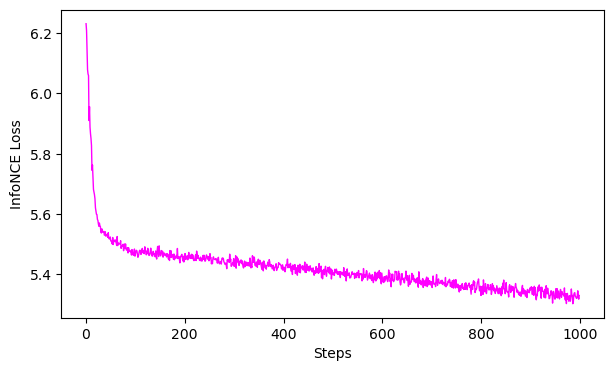

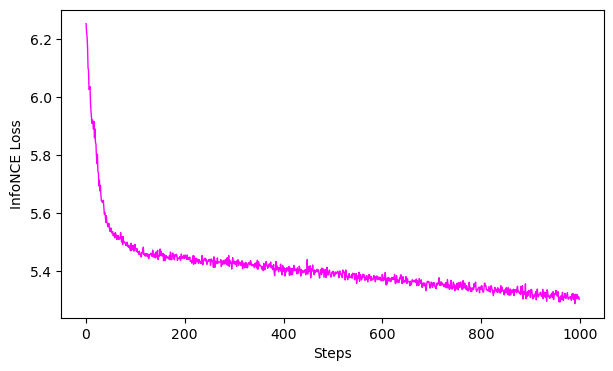

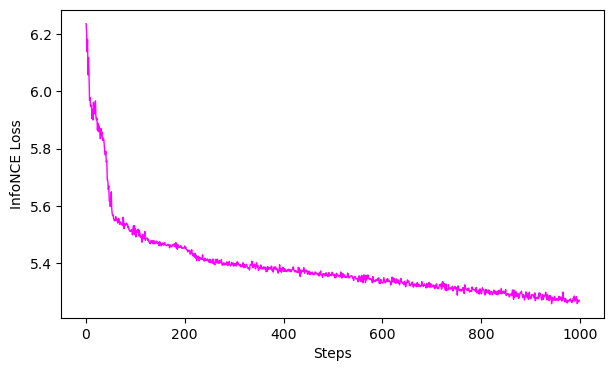

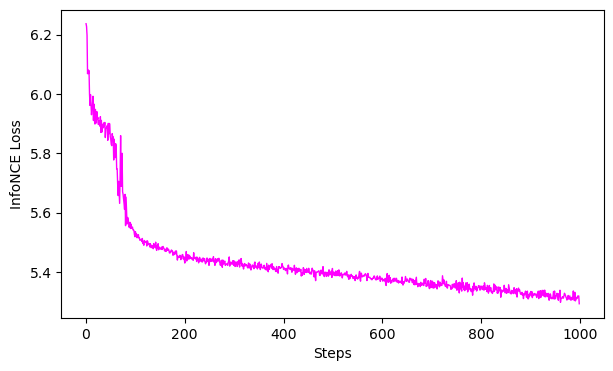

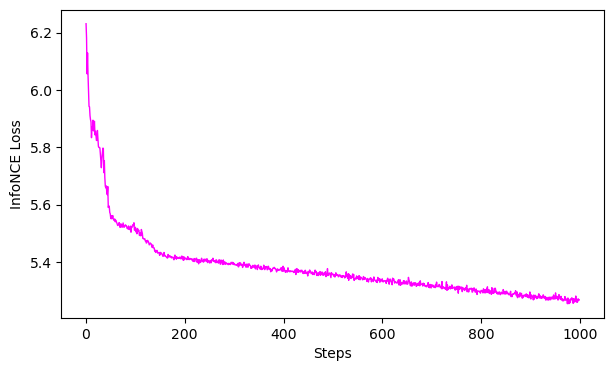

In [26]:
def get_feature_names_and_mean_scores(
    dataset_dict, accuracy, marker: str, filtered_channel: str
):
    if marker != "EEG":
        return list(dataset_dict[marker].keys()), [
            accuracy[marker][f] for f in all_feature_name
        ]

    if len(filtered_channel) == 0:
        all_feature_name = list(dataset_dict.keys())
        mean_scores = [accuracy[c][Feature.ALL_SPECTRAL] for c in all_feature_name]
    else:
        all_feature_name = list(dataset_dict[filtered_channel].keys())
        mean_scores = [accuracy[filtered_channel][f] for f in all_feature_name]

    return all_feature_name, mean_scores


subject_accuracy_summary = {
    "subject": [],
    "channel": [],
    "cv_mean_score": [],
}
###CHANGE ME####
method = "CEBRA"
filtered_channel = "C"
plot_roc = False
all_spectral_only = True
###############
label_type = "valence-arousal"
test_subject_list =  subject_list #['2001', '2005', '2031'] #
subject_to_embedding = {s: {label_type: []} for s in test_subject_list}
subject_to_shuffled_indexes = {s: {label_type: []} for s in test_subject_list}

for idx in range(len(test_subject_list)):
    subj = test_subject_list[idx]
    
    print("decoding subject...", subj)

    v_thred, a_thred = label_thresholds[idx]
    labels = cat_labels[idx]
    dataset =  EEGDataset(val_indexes)
    subject_to_shuffled_indexes[subj][label_type] = dataset.get_shuffled_indexes(labels, False)

    dataset_dict = prepare_dataset(
        marker_features[idx],
        dataset,
        labels,
        all_spectral_only,
    )

    subject_to_embedding[subj][label_type], accuracy = decode_marker_data(
        dataset_dict, method, filtered_channel, plot_roc
    )
    
    all_feature_name, mean_scores = get_feature_names_and_mean_scores(
        dataset_dict, accuracy, marker, filtered_channel
    )
    subject_accuracy_summary["subject"].extend(
        [test_subject_list[idx]] * len(all_feature_name)
    )
    subject_accuracy_summary["channel"].extend(all_feature_name)
    subject_accuracy_summary["cv_mean_score"].extend(mean_scores)

subject_accuracy_summary = pd.DataFrame(subject_accuracy_summary)
subject_accuracy_summary["subject"] = subject_accuracy_summary["subject"].astype(int)

In [27]:
identifier = 'no_shuffled_test_1000iter_valence_arsoual_c_all_spectral'
with open(f'results/models/{identifier}_embeddings.pkl', 'wb') as handle:
    pickle.dump(subject_to_embedding, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
subject_accuracy_summary["channel"] = subject_accuracy_summary["channel"].astype(str)
subject_accuracy_summary.to_csv(f'results/{method}_valence_arousal_C_spectral.csv')

In [ ]:
with open(f'results/models/{identifier}_indexes.pkl', 'wb') as handle:
    pickle.dump(subject_to_shuffled_indexes, handle, protocol=pickle.HIGHEST_PROTOCOL)

/Users/ccnlab/miniconda3/envs/MM/lib/python3.8/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


Text(0.5, 1.0, 'EEG C channel - CEBRA')

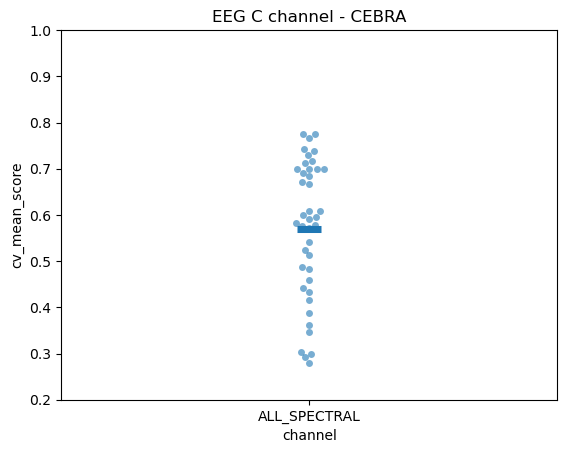

In [30]:
data = subject_accuracy_summary
title = f"EEG C channel - {method}"  #
g = sns.swarmplot(
    data=data,
    x="channel",
    y="cv_mean_score",
    #hue='subject',
    alpha=0.6,
    dodge=True,
    legend=False,
)
g.set_ylim((0.2, 1))

df_means = data.groupby(["channel"])["cv_mean_score"].agg("mean").reset_index()
pp = sns.pointplot(
    x="channel",
    y="cv_mean_score",
    data=df_means,
    dodge=0.6,
    linestyles="",
    errorbar=None,
    scale=2.5,
    markers="_",
    # order=[
    #     "DELTA",
    #     "THETA",
    #     "ALPHA",
    #     "BETA1",
    #     "BETA2",
    #     "GAMMA",
    #     'ALL_SPECTRAL'
    # ],
)
#pp.set_xticklabels(['DELTA', 'THETA', 'ALPHA', 'BETA1', 'BETA2', 'GAMMA', 'ALL_SPECTRAL'], rotation=40)

g.set_title(title)